# Springboard Capstone 2: 
## Covid-19 Wastewater Surveillance Prediction
### Author: Nantawat Samermit

## Executive Summary

### Problem:
The Sars-CoV-19 or 'Covid-19' virus is an ongoing pandemic. Businesses and communities are being affected with each wave. Wastewater surveillance is a non-invasive way to measure mRNA concentrations of the virus.

### Exploratory Research Question:
Can we use the viral concentration surveilled from wastewater to predict a surge?


### Methods
    1. Using supervised learning see if I can predict the trend of 'Change Since Last Week' using the features in my dataset
    2. Using time-series models to forecast the concentration of Covid-19 mRNA in surveilled wastewater.

### Results
    1. KNN yielded the most accurate prediction, but I could only p on one city's data. Inconclusive.
    2. Time-series models yields a forecast, but my issues with the size and the stationarity of the dataset impedes further progress.

### Implications
I believe that using a forecast of Covid-19 mRNA concentration in wastewater could be used as an indicator to the presence of Covid-19 in that area. However this is with the following assumption:
1. Wastewater will be continuosly surveilled
2. Viral shedding persists into wastewater with any future dominant variants

# Data Scraping (Unit 7.2)
I'll be scraping three datasets. 

The first is from the Cambridge MA wastewater data archive. It is listed as JSON, which I will convert to a pandas DataFrame. 

The URL is here: 'https://data.cambridgema.gov/resource/ayt4-g2ye.json'


The second dataset is from Massachusetts Department of Health. 

The URL is here: 'https://www.mass.gov/doc/covid-19-raw-data-june-15-2021/download'

The third dataset is from Biobot's Github: https://github.com/biobotanalytics/covid19-wastewater-data/blob/master/wastewater_by_county.csv

I downloaded the third dataset from Github and added it to the Biobot Data folder.

In [4]:
#import relevant modules for data wrangling - keep on adding as needed
import pandas as pd
import json, requests
import fuzzywuzzy 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#for web-scraping in Data Wrangling Module
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

#for saving pickle files in Data Wrangling Module
import pickle


#For Preprocessing
from sklearn import preprocessing
import statsmodels.api as sm
import pmdarima as pm
import random as random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import statsmodels.graphics.tsaplots as tsaplots

from statsmodels.tsa.arima_model import ARIMA
# Silencing the ARIMA deprecation warning
import warnings


## Notes regarding Massachusetts Data
After some attempts, it seems the Massachusetts dataset is a multi-page csv, and it isn't easily accessible.

I will have to use BeautifulSoup to isolate the link to the excel file.

In [2]:
# Use BS to identify/isolate the html "class" pointing to the href of the .xls 
#class and "ma__download-link__file-link" was identified by inspecting the page's elements in chrome
source = requests.get("https://www.mass.gov/doc/covid-19-raw-data-july-29-2021")
BeautifulSoup(source.content).find("a", {"class":"ma__download-link__file-link"}).get("href")

'/doc/covid-19-raw-data-july-29-2021/download'

BeautifulSoup has isloated the href link for the .xls spreadsheet. 

It is here: https://www.mass.gov/doc/covid-19-raw-data-july-29-2021/download

## Scrape, Download, and Save datasets
I will write a function to scrape, convert, and save both datasets to my directory as pickle files. 

In [3]:
#Luka states it is easier (and acceptable) to just download the files to local path. 

#For the mass.gov dataset, it has mulitiple sheets, so it isolates the intended sheet. (not dynamic, ikr)

def get_sources(source_list):
    '''
    this function takes a list of urls, ID's their format, requests dataset from source,
    converts data into a dataframe, then saves it as a pickled file.
    '''
    for counter, source in enumerate(source_list):
        name = str(counter) + '_df.pkl'

        if source.endswith('.json'):
            response = requests.get(source)
            data = response.json()
            json_df = pd.DataFrame(data)            
            json_df.to_pickle(name)
            
        
        elif source.endswith('.csv'):
            csv = pd.read_csv(source, engine='python')
            csv.to_pickle(name)
            
        else:
            response = requests.get(source, allow_redirects=True)
            with open('excel_data.xlsx', 'wb') as file:
                file.write(response.content)
            
            #using pd.read_excel on a multi-spreadsheet xls yields a dictionary
            excel_dict = pd.read_excel('excel_data.xlsx', sheet_name=None)
            name = str(counter) + '_df.pkl'
            #can ID sheetnames by evaluating keys
            #print(excel_dict.keys())
            if len(excel_dict.keys()) > 1:
                print('There are more than one sheet in this .csv file.','\n',
                      source, '\n', excel_dict.keys())
                myInput = input('Which of these sheets do  you want to use?')
                #print(myInput)
                excel_specified_sheet = excel_dict[myInput]
                excel_specified_sheet.to_pickle(name)
            else:
                excel_dict.to_pickle(name)
            
        print(name,' created using this source', source)

In [ ]:
sources = ['https://data.cambridgema.gov/resource/ayt4-g2ye.json', 
           'https://www.mass.gov/doc/covid-19-raw-data-july-29-2021/download',
           'Biobot Data/wastewater_by_county.csv' 
          ]

#old_source = 'https://www.mass.gov/doc/covid-19-raw-data-june-15-2021/download'

get_sources(sources)

## Use pickle to confirm the saved files can be loaded in Jupyter

In [5]:
#should use context manager to load pickles 
# Don't forget to state 'rb' param or will get an Unicode Error.

    
with open('0_df.pkl', 'rb') as f:
    Cambridge_df = pickle.load(f)
    
with open('1_df.pkl', 'rb') as f:
    Mass_df = pickle.load(f)

with open('2_df.pkl', 'rb') as f:
    Biobot_df = pickle.load(f)

In [5]:
#testing both dataframes
Cambridge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date                          309 non-null    object
 1   mwra_concentration            309 non-null    object
 2   mwra_7dayaverage              309 non-null    object
 3   concentration_mid_cambridge   309 non-null    object
 4   concentration_east_cambridge  309 non-null    object
 5   concentration_cambridgeport   309 non-null    object
 6   concentration_north_west      309 non-null    object
 7   highci_mid_cambridge          309 non-null    object
 8   highci_east_cambridge         309 non-null    object
 9   highci_cambridgeport          309 non-null    object
 10  highci_north_west_cambridge   309 non-null    object
 11  lowci_mid_cambridge           309 non-null    object
 12  lowci_east_cambridge          309 non-null    object
 13  lowci_cambridgeport 

In [6]:
Mass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11296 entries, 0 to 11295
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   City/Town                   11296 non-null  object        
 1   County                      11296 non-null  object        
 2   Population                  11296 non-null  object        
 3   Total Case Counts           11296 non-null  object        
 4   Two Week Case Counts        11296 non-null  object        
 5   Average Daily Rate          11296 non-null  object        
 6   Color                       9495 non-null   object        
 7   Change in Last Week         11296 non-null  object        
 8   Total Tests                 11296 non-null  int64         
 9   Total Tests Last Two Weeks  11295 non-null  float64       
 10  Total Positive Tests        11295 non-null  float64       
 11  Percent Positivity          11295 non-null  object    

In [7]:
Biobot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   sampling_week                             1267 non-null   object 
 1   normalized_concentration_rolling_average  1267 non-null   float64
 2   population                                1267 non-null   object 
 3   region                                    1267 non-null   object 
 4   state                                     1267 non-null   object 
 5   county_fips_code                          1267 non-null   int64  
 6   county_name                               1267 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 69.4+ KB


# Data Wrangling (Unit 7.2)
Explore the dataset. Understand the datatypes for the various columns, and confirm that there are no missing values.

## Cambridge Data

In [8]:
Cambridge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date                          309 non-null    object
 1   mwra_concentration            309 non-null    object
 2   mwra_7dayaverage              309 non-null    object
 3   concentration_mid_cambridge   309 non-null    object
 4   concentration_east_cambridge  309 non-null    object
 5   concentration_cambridgeport   309 non-null    object
 6   concentration_north_west      309 non-null    object
 7   highci_mid_cambridge          309 non-null    object
 8   highci_east_cambridge         309 non-null    object
 9   highci_cambridgeport          309 non-null    object
 10  highci_north_west_cambridge   309 non-null    object
 11  lowci_mid_cambridge           309 non-null    object
 12  lowci_east_cambridge          309 non-null    object
 13  lowci_cambridgeport 

In [9]:
Cambridge_df.describe()

,date,mwra_concentration,mwra_7dayaverage,concentration_mid_cambridge,concentration_east_cambridge,concentration_cambridgeport,concentration_north_west,highci_mid_cambridge,highci_east_cambridge,highci_cambridgeport,highci_north_west_cambridge,lowci_mid_cambridge,lowci_east_cambridge,lowci_cambridgeport,lowci_north_west_cambridge
count,309,309,309,309,309,309,309,309,309,309,309,309,309,309,309
unique,309,243,228,30,36,27,34,30,36,27,34,30,36,27,34
top,2021-04-15T00:00:00.000,,20,,,,,,,,,,,,
freq,1,11,6,273,271,275,271,273,271,275,271,273,271,275,271


# Note to myself:
For my own review!

Column Definitions:
Date - sample date for 24 hour composite sample


MWRA_Concentration - Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.


MWRA_7DayAverage - 7 day rolling average for Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.


Concentration_* - Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.


highci_* - Upper Limit on Confidence Interval for Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.


lowci_* - Lower Limit on Confidence Interval for Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.
* means there are multiple columns with this prefix which share the same definition - Nantawat

A refresher on confidence interval limits - https://bit.ly/3vtuI7h


## Features observations:
1. All the features pf Cambridge_df are object dtypes.
2. describe() states they (15 features) are all non-null values. Let's confirm that.

In [10]:
#This confirms that none of the features contain null values. 
Cambridge_df.isnull().sum()

date                            0
mwra_concentration              0
mwra_7dayaverage                0
concentration_mid_cambridge     0
concentration_east_cambridge    0
concentration_cambridgeport     0
concentration_north_west        0
highci_mid_cambridge            0
highci_east_cambridge           0
highci_cambridgeport            0
highci_north_west_cambridge     0
lowci_mid_cambridge             0
lowci_east_cambridge            0
lowci_cambridgeport             0
lowci_north_west_cambridge      0
dtype: int64

In [11]:
#This will show that although isnull().sum() returns 0 null values, the cells look blank!
Cambridge_df.head(5)

,date,mwra_concentration,mwra_7dayaverage,concentration_mid_cambridge,concentration_east_cambridge,concentration_cambridgeport,concentration_north_west,highci_mid_cambridge,highci_east_cambridge,highci_cambridgeport,highci_north_west_cambridge,lowci_mid_cambridge,lowci_east_cambridge,lowci_cambridgeport,lowci_north_west_cambridge
0,2020-10-01T00:00:00.000,,31,,,,,,,,,,,,
1,2020-10-02T00:00:00.000,34,31,,,,,,,,,,,,
2,2020-10-03T00:00:00.000,,31,,,,,,,,,,,,
3,2020-10-04T00:00:00.000,,31,,,,,,,,,,,,
4,2020-10-05T00:00:00.000,38,30,,,,,,,,,,,,


In [12]:
#Just incase I need to examine this data one day... 
Cambridge_non_blank_data = pd.DataFrame(Cambridge_df.loc[Cambridge_df['concentration_mid_cambridge'] != ''])

### This does not pass the stench test! mwra_concentration is not 100% non-null

In [13]:
#Check these blank cells to confirm they are 'filled' with whitespaces
Cambridge_df['mwra_concentration'][0] == ''

True

In [6]:
#create a method using the logic from the cell above to check for blank cells
def blank_check(df):
    ''' A method to check my column cells from a pandas DataFrame for whitespace blanks.'''
    return dict(zip(df.columns, [(df[x] == '').sum() for x in df.columns]))

In [7]:
blank_check(Cambridge_df)

{'date': 0,
 'mwra_concentration': 12,
 'mwra_7dayaverage': 1,
 'concentration_mid_cambridge': 289,
 'concentration_east_cambridge': 287,
 'concentration_cambridgeport': 292,
 'concentration_north_west': 288,
 'highci_mid_cambridge': 289,
 'highci_east_cambridge': 287,
 'highci_cambridgeport': 292,
 'highci_north_west_cambridge': 288,
 'lowci_mid_cambridge': 289,
 'lowci_east_cambridge': 287,
 'lowci_cambridgeport': 292,
 'lowci_north_west_cambridge': 288}

### Looking at how many 'blank' whitespace cells those features have, I think it is prudent to drop them first

In [8]:
kept_features = ['date', 'mwra_concentration', 'mwra_7dayaverage']
Cambridge_df.drop(columns=Cambridge_df.columns.difference(kept_features), inplace=True)

In [9]:
#confirm those columns were dropped
Cambridge_df.describe()

,date,mwra_concentration,mwra_7dayaverage
count,328,328,328
unique,328,253,239
top,2021-08-11T00:00:00.000,,20
freq,1,12,6


In [10]:
#confirm how many blank cells to wrangle
blank_check(Cambridge_df)

{'date': 0, 'mwra_concentration': 12, 'mwra_7dayaverage': 1}

### At this point - Choose:
1. Drop those rows with blank columns
2. Impute them with something
    
    A: Can be the mwra_7dayaverage
    
    B: Can be a front-fill method    
    
    C:  Can be a back-fill method

#### I chose option 2, and I want to fill with the mwra_7dayaverage where I can. 

In [11]:
#change 'date' feature into a datetime and assign to index
Cambridge_df.date = pd.to_datetime(Cambridge_df.date)
Cambridge_df.set_index('date', inplace=True)

In [12]:
#blank check before the whitespace replacement
blank_check(Cambridge_df)

{'mwra_concentration': 12, 'mwra_7dayaverage': 1}

In [13]:
#replace whitespace with NaN and check for an decrease in blank_check and increase in null
#The increase seen with .isnull() is due to us replacing '' with 
Cambridge_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [14]:
#blank check after whitespace replacement
blank_check(Cambridge_df)

{'mwra_concentration': 0, 'mwra_7dayaverage': 0}

In [15]:
Cambridge_df.isnull().sum()

mwra_concentration    12
mwra_7dayaverage       1
dtype: int64

#### This passes the stench test now, and we can easily deal with NaNs.

In [16]:
#replace mwra_7dayaverage NaNs with .replace() and frontfill method
Cambridge_df.mwra_7dayaverage.replace(np.nan, method='ffill', inplace=True)

#replace mwra_concentration NaNs with the given mwra_7dayaverage using .fillna()
Cambridge_df.mwra_concentration.fillna(Cambridge_df.mwra_7dayaverage, inplace=True)

Cambridge_df.isnull().sum()

mwra_concentration    0
mwra_7dayaverage      0
dtype: int64

In [17]:
Cambridge_cleaned = Cambridge_df.copy()

## Masschusetts Data

In [18]:
Mass_df.shape

(11296, 17)

In [19]:
Mass_df.columns

Index(['City/Town', 'County', 'Population', 'Total Case Counts',
       'Two Week Case Counts', 'Average Daily Rate', 'Color',
       'Change in Last Week', 'Total Tests', 'Total Tests Last Two Weeks',
       'Total Positive Tests', 'Percent Positivity', 'Change Since Last Week',
       'Testing Rate', 'Report Date', 'Start_Date', 'End_Date'],
      dtype='object')

In [20]:
Mass_df.County.value_counts()

Worcester     1920
Middlesex     1728
Essex         1088
Berkshire     1024
Norfolk        896
Plymouth       864
Franklin       832
Hampden        736
Hampshire      640
Bristol        640
Barnstable     480
Dukes          224
Suffolk        128
Nantucket       32
Unknown         32
Statewide       32
Name: County, dtype: int64

In [21]:
num_nulls = Mass_df.isnull().sum()
print(blank_check(Mass_df), num_nulls)

{'City/Town': 0, 'County': 0, 'Population': 0, 'Total Case Counts': 0, 'Two Week Case Counts': 0, 'Average Daily Rate': 0, 'Color': 0, 'Change in Last Week': 0, 'Total Tests': 0, 'Total Tests Last Two Weeks': 0, 'Total Positive Tests': 0, 'Percent Positivity': 0, 'Change Since Last Week': 0, 'Testing Rate': 0, 'Report Date': 0, 'Start_Date': 0, 'End_Date': 0} City/Town                        0
County                           0
Population                       0
Total Case Counts                0
Two Week Case Counts             0
Average Daily Rate               0
Color                         1801
Change in Last Week              0
Total Tests                      0
Total Tests Last Two Weeks       1
Total Positive Tests             1
Percent Positivity               1
Change Since Last Week           0
Testing Rate                     4
Report Date                      0
Start_Date                       0
End_Date                         0
dtype: int64


#### I've decided to drop columns after I merge the Massachusetts and Biobot dfs.

## Biobot Data

In [22]:
Biobot_df.isnull().sum()

sampling_week                               0
normalized_concentration_rolling_average    0
population                                  0
region                                      0
state                                       0
county_fips_code                            0
county_name                                 0
dtype: int64

In [23]:
blank_check(Biobot_df)

{'sampling_week': 0,
 'normalized_concentration_rolling_average': 0,
 'population': 0,
 'region': 0,
 'state': 0,
 'county_fips_code': 0,
 'county_name': 0}

In [24]:
Biobot_df.shape

(1267, 7)

In [25]:
print(Biobot_df.state.value_counts(), Biobot_df.state.value_counts().sum())

MA    257
PA    184
CA    141
IN     81
TN     65
FL     59
NV     58
KY     55
CT     54
OR     49
VA     49
CO     48
NY     38
DE     36
IL     35
MN     30
NJ     28
Name: state, dtype: int64 1267


Biobot performed the most WBE surveillance in Massachusetts. Affirms my choice to use their dataset.

In [26]:
#Let's slice for MA data only
Biobot_MA = pd.DataFrame(Biobot_df.loc[Biobot_df.state=='MA'])

In [27]:
Biobot_MA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257 entries, 146 to 714
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   sampling_week                             257 non-null    object 
 1   normalized_concentration_rolling_average  257 non-null    float64
 2   population                                257 non-null    object 
 3   region                                    257 non-null    object 
 4   state                                     257 non-null    object 
 5   county_fips_code                          257 non-null    int64  
 6   county_name                               257 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 16.1+ KB


### Comparing Biobot's wastewater data to Cambridge

In [28]:
pd.DataFrame(Cambridge_df.loc['2020-Dec':'2021-Jan', ('mwra_concentration', 'mwra_7dayaverage')])

,mwra_concentration,mwra_7dayaverage
date,,
2020-12-01,862,576
2020-12-02,857,630
2020-12-03,888,685
2020-12-04,1384,779
2020-12-05,956,844
...,...,...
2021-01-27,350,549
2021-01-28,421,523
2021-01-29,329,470


In [29]:
#this cell is broken as I moved it around. Could run this check after resetting biobot_MA's index to sampling_date
bio_middlesex = pd.DataFrame(Biobot_MA.
                             loc[Biobot_MA['county_name'] == 'Middlesex'])

bio_middlesex.loc['2020-Dec':'2021-Jan', 'normalized_concentration_rolling_average']
pd.DataFrame(bio_middlesex.loc['2020-Dec':'2021-Jan', 'normalized_concentration_rolling_average'])
#bio_middlesex.loc[bio_middlesex['2020-Dec':'2021-Jan'], 'normalized_concentration_rolling_average']

,normalized_concentration_rolling_average


The Cambrdge_df mwra (a measure of covid-19 rna concentration in wastewater) doesn't look like it matches Biobot's. 
I cannot explain this discrepancy yet. 
As Biobot has the larger dataset, I think I will use that over Cambridge_df.

## Merging Mass_df and Biobot_MA DataFrames

### Set the indices for all df to a 'period' datetime range, with week starting on Monday

In [30]:
#setting the indices to all 3 dfs to be a datetime
#cam_date = pd.to_datetime(Cambridge_df.date, infer_datetime_format=True)
#Cambridge_df.set_index(cam_date, inplace=True)

mass_date = pd.to_datetime(Mass_df['Report Date'], infer_datetime_format=True)
Mass_df.set_index(mass_date, 
                  inplace=True)

biobot_date = pd.to_datetime(Biobot_MA['sampling_week'], infer_datetime_format=True)
Biobot_MA.set_index(biobot_date, 
                    inplace=True)

In [31]:

#Creating a period feature, using W-MON as the parameter
# I do this so I can easily merge these dfs on a standardized time, as the dates on the reports may not match other dfs
Cambridge_df['per'] = Cambridge_df.index.to_period('W-MON')
Mass_df['per'] = Mass_df.index.to_period('W-MON')
Biobot_MA['per'] = Biobot_MA.index.to_period('W-MON')

### Slicing by the common_periods shared throughout the dfs

In [32]:
#this is no longer needed now I know how to merge on multiple columns. Keeping for review
#Mass_sliced_by_common_periods = pd.DataFrame(Mass_df.loc[Mass_df['per'].isin(common_periods)])
#Biobot_MA_sliced_by_common_periods = pd.DataFrame(Biobot_MA.loc[Biobot_MA['per'].isin(common_periods)])

In [33]:
#These names are a mouthful, changing to shorter ones
df_b = pd.DataFrame(Biobot_MA)
df_m = pd.DataFrame(Mass_df)

#unifying the County features between the two df
df_b['County'] = df_b['county_name']

#dropping redundant or non-interested features from df_b
drop_list = ['region', 'state', 'county_fips_code', 'county_name']
df_b.drop(columns=drop_list, inplace=True)

#dropping redundant or non-interested features from df_m
kept_list = ['City/Town', 'County', 'Change Since Last Week', 'Percent Positivity', 'per', 'Report Date']
df_m.drop(columns=df_m.columns.difference(kept_list), inplace=True)

In [34]:
#As this is statewide data from MA Dept of Health, all the counties and their reports amount to a large number
num_reports = df_m.County.value_counts().sum()
num_counties = df_m.County.nunique()
print(num_reports, num_counties)

11296 16


In [35]:
#However Biobot only conducted wastewater surveillance at a select number of counties
bio_num_reports = df_b.County.value_counts().sum()
bio_num_counties = df_b.County.nunique()
print(bio_num_reports, bio_num_counties)

257 6


### Merging

In [36]:
#doing an inner merge, and we can specify multiple columns on which it will merge
merged_df = df_b.merge(df_m, how='inner', on=['County', 'per'])

### Reviewing and Wranging the merged_df

In [37]:
merged_df.head()

,sampling_week,normalized_concentration_rolling_average,population,per,County,City/Town,Percent Positivity,Change Since Last Week,Report Date
0,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Adams,0.028758,Lower,2020-12-24
1,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Alford,0,No Change,2020-12-24
2,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Becket,0.04,Higher,2020-12-24
3,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Cheshire,0.024055,Higher,2020-12-24
4,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Clarksburg,0.010101,Lower,2020-12-24


In [38]:
#expect the number of counties to match bio_num_counties
merged_num_counties = merged_df.County.nunique()
print(bio_num_counties, merged_num_counties)

6 6


In [39]:
merged_df.shape

(3162, 9)

In [40]:
merged_df.duplicated().any()

False

In [41]:
merged_df.isnull().sum()

sampling_week                               0
normalized_concentration_rolling_average    0
population                                  0
per                                         0
County                                      0
City/Town                                   0
Percent Positivity                          0
Change Since Last Week                      0
Report Date                                 0
dtype: int64

In [42]:
blank_check(merged_df)

{'sampling_week': 0,
 'normalized_concentration_rolling_average': 0,
 'population': 0,
 'per': 0,
 'County': 0,
 'City/Town': 0,
 'Percent Positivity': 0,
 'Change Since Last Week': 0,
 'Report Date': 0}

In [43]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   object        
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   object        
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   object        
 5   City/Town                                 3162 non-null   object        
 6   Percent Positivity                        3162 non-null   object        
 7   Change Since Last Week                    3162 non-null   object        
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1

### In what I would expect to be my categorical features, I am checking and counting unique values

In [44]:
cat_list = ['population', 'County', 'City/Town', 'Change Since Last Week']
[merged_df[x].value_counts() for x in cat_list]

[100000-200000      1296
 20000-50000         968
 50000-100000        640
 10000-20000         158
 2000000-5000000     100
 Name: population, dtype: int64,
 Middlesex    1350
 Essex         748
 Berkshire     640
 Hampshire     300
 Suffolk       100
 Nantucket      24
 Name: County, dtype: int64,
 Acton          25
 Boxborough     25
 Natick         25
 Lowell         25
 Lexington      25
                ..
 Cummington     15
 Westhampton    15
 Goshen         15
 Hadley         15
 Belchertown    15
 Name: City/Town, Length: 145, dtype: int64,
 Lower        1402
 Higher        953
 No Change     587
 Lower         220
 Name: Change Since Last Week, dtype: int64]

In [45]:
#In the 'Change Since Last Week' column, 'Lower' shows up twice in the value_counts()
merged_df['Change Since Last Week'].value_counts()

Lower        1402
Higher        953
No Change     587
Lower         220
Name: Change Since Last Week, dtype: int64

In [46]:
#I suspect there is a whitespace after the r in one of them
(merged_df['Change Since Last Week'].values == 'Lower ').sum()

220

In [47]:
#confirmed 220 with whitespace, replacing.
merged_df['Change Since Last Week'].replace('Lower ', 'Lower', inplace=True)

In [48]:
merged_df['Change Since Last Week'].value_counts()

Lower        1622
Higher        953
No Change     587
Name: Change Since Last Week, dtype: int64

In [49]:
(merged_df['Change Since Last Week'].values == 'Lower ').sum()

0

In [50]:
cleaned_df = merged_df.copy()

In [51]:
blank_check(cleaned_df), cleaned_df.isnull().sum()

({'sampling_week': 0,
  'normalized_concentration_rolling_average': 0,
  'population': 0,
  'per': 0,
  'County': 0,
  'City/Town': 0,
  'Percent Positivity': 0,
  'Change Since Last Week': 0,
  'Report Date': 0},
 sampling_week                               0
 normalized_concentration_rolling_average    0
 population                                  0
 per                                         0
 County                                      0
 City/Town                                   0
 Percent Positivity                          0
 Change Since Last Week                      0
 Report Date                                 0
 dtype: int64)

## Note about this merged dataframe:
1. I think this is considered an inner merge. Based on the 'per' and 'County' columns.
2. Inner Join imputed the many features from the Mass_df to Biobot_MA.
3. Ready for EDA 7.26.21 NS

In [52]:
#Some summary statistics
cleaned_df.describe(), cleaned_df.shape

(       normalized_concentration_rolling_average
 count                               3162.000000
 mean                                 195.761188
 std                                  220.679590
 min                                    0.000000
 25%                                   50.628972
 50%                                  108.200214
 75%                                  265.228983
 max                                 1548.370985,
 (3162, 9))

### At every Unit submission, I will create a new pickle file.

In [53]:
#cleaned_df.to_pickle('Unit11EDA.pkl') #Created 7.27.21. Updated 8.11.21 NS

# Exploratory Data Analysis (Unit 11.5)

### Goal from the rubric:
1. Investigate every feature using histograms, bi-plots, or other visual and numeric means
2. Pearson correlation coefficients and other statistical methods were used to ID statistical relationship strengths

In [54]:
with open('Unit11EDA.pkl', 'rb') as f:
    df = pickle.load(f)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   object        
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   object        
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   object        
 5   City/Town                                 3162 non-null   object        
 6   Percent Positivity                        3162 non-null   object        
 7   Change Since Last Week                    3162 non-null   object        
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1

### The types of the features may be problematic when trying to run statistical analysis. Let's see what types they should be, and then do the proper vectorized conversion.

In [56]:
#As always, I use copy when doing any testing
test = df.copy()

In [57]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   object        
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   object        
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   object        
 5   City/Town                                 3162 non-null   object        
 6   Percent Positivity                        3162 non-null   object        
 7   Change Since Last Week                    3162 non-null   object        
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1

### Here's how I think they should be converted
1. Category = ['population', 'County', 'City/Town', 'Change Since Last Week']
2. Float64 = ['avg_concentration', 'Percent Positivity']
3. Datetime = ['sampling_week', 'Report Date']

Will create a unit test first.

In [58]:

category_list = ['population', 'County', 'City/Town', 'Change Since Last Week']

float64_list = ['normalized_concentration_rolling_average', 'Percent Positivity']

datetime_list = ['sampling_week']

conversion_list = [datetime_list, category_list, float64_list]

In [59]:
#Unit testing my conversion loop logic
for list in conversion_list:
    print(list)
    for col in list:
        if col in datetime_list:
            print('Will convert these to datetime: ', col)
        if col in category_list:
            print('Will convert these to category: ',col)
        if col in float64_list:
            print('Will convert these to float64: ', col)

['sampling_week']
Will convert these to datetime:  sampling_week
['population', 'County', 'City/Town', 'Change Since Last Week']
Will convert these to category:  population
Will convert these to category:  County
Will convert these to category:  City/Town
Will convert these to category:  Change Since Last Week
['normalized_concentration_rolling_average', 'Percent Positivity']
Will convert these to float64:  normalized_concentration_rolling_average
Will convert these to float64:  Percent Positivity


In [60]:
for list in conversion_list:
    for col in list:
        if col in datetime_list:
            test[col] = pd.to_datetime(test[col], infer_datetime_format=True)
            #print('These should be converted to int64: ', col)
        if col in category_list:
            test[col] = test[col].astype('category')
            #print('These should be converted to categories: ', col)
        if col in float64_list:
            test[col] = test[col].astype('float64')
            #print('These should be converted to float64: ', col)


In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   datetime64[ns]
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   category      
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   category      
 5   City/Town                                 3162 non-null   category      
 6   Percent Positivity                        3162 non-null   float64       
 7   Change Since Last Week                    3162 non-null   category      
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: category(4), datetime64[ns](

### Conversion unit test passes, convert all features in df

In [62]:
def conversion(df, conversion_list):
    '''Method to convert my features into their appropriate datatypes'''
    for list in conversion_list:
        for col in list:
            if col in datetime_list:
                df[col] = pd.to_datetime(test[col], infer_datetime_format=True)
            if col in category_list:
                df[col] = df[col].astype('category')
            if col in float64_list:
                df[col] = df[col].astype('float64')

In [63]:
#Pre-conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   object        
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   object        
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   object        
 5   City/Town                                 3162 non-null   object        
 6   Percent Positivity                        3162 non-null   object        
 7   Change Since Last Week                    3162 non-null   object        
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1

In [64]:
conversion(df, conversion_list)

In [65]:
#Post-conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   datetime64[ns]
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   category      
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   category      
 5   City/Town                                 3162 non-null   category      
 6   Percent Positivity                        3162 non-null   float64       
 7   Change Since Last Week                    3162 non-null   category      
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: category(4), datetime64[ns](

### Dtypes have been converted to the intended type, let's do some Exploratory Data Analysis!

It's always a good idea to get a sense of the data's distribution.
Here's what I'm interested in:
1. avg_concentration - float64
2. Change Since Last Week - categorical
3. Percent Positivity - float64

C:\Users\Aim\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'normalized_concentration_rolling_average Distribution')

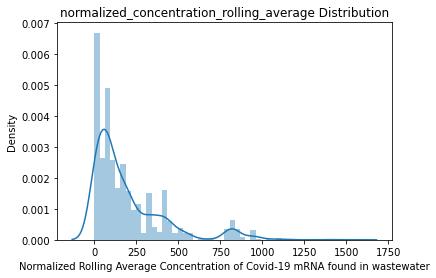

In [66]:
#This is NOT a normal distribution. Uh-oh...
sns.distplot(df.normalized_concentration_rolling_average)
plt.xlabel('Normalized Rolling Average Concentration of Covid-19 mRNA found in wastewater')
plt.title('normalized_concentration_rolling_average Distribution')

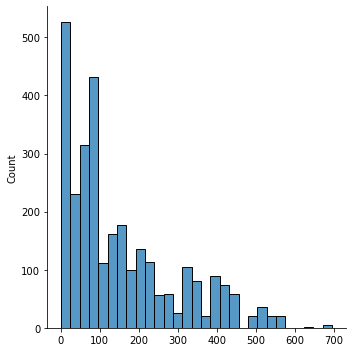

In [67]:
#setting a threshold of less than 700 to see if I can yield a more normal dist
data = [x for x in df.normalized_concentration_rolling_average if x <700]
sns.displot(data)

### Distribution takeaways:
1. Concentration and Positivity are not uniform, shows skewedness
2. In Change Since the majority of the datapoints are 'lower'
3. in Change Since, the 'Higher' category seems to have the higher avg_concentration values

Let's explore any correlation gained from this insight.

In [68]:
#I need to drop some features or my system won't be able to process the dummy variables for the .corr()

#Why did I think I needed to drop these features?
test = pd.DataFrame(df.drop(columns=['City/Town', 'County', 'population']))
#test = df.copy()

#test = pd.DataFrame(df.drop(columns=['population']))

In [69]:
#I know dummies should be reserved to pre-processing but I couldn't help myself
test = pd.get_dummies(test)

<AxesSubplot:>

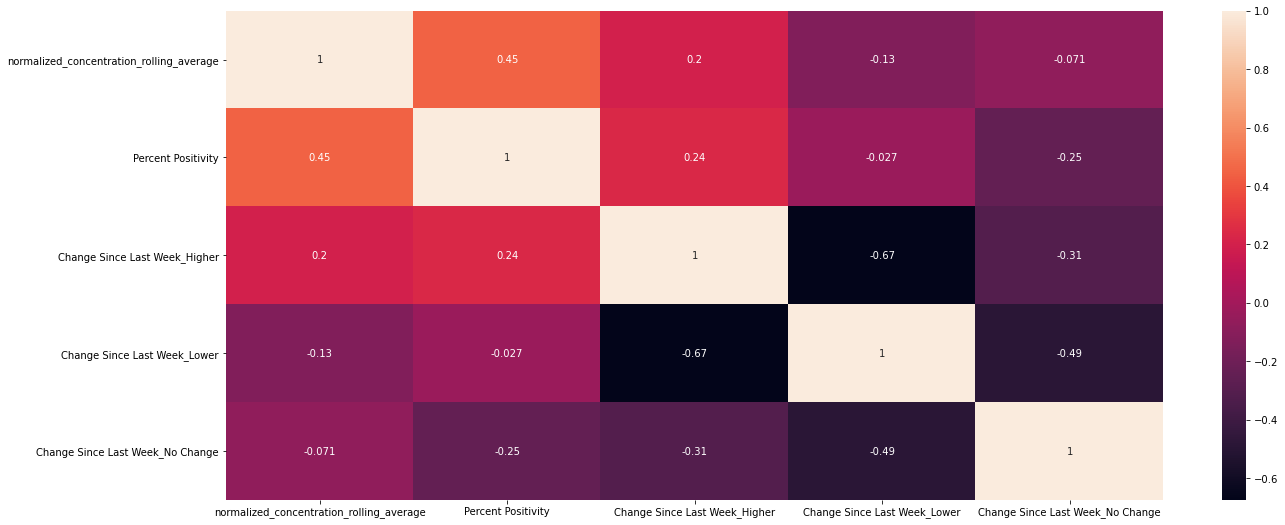

In [70]:
plt.figure(figsize = (21,9))
sns.heatmap(test.corr(), annot=True)

The heatmap is a great visual tool, as it looks at all the non-categorical data, and with the right parameters even annotates their Pearson r value.

In [78]:
#If I didn't want that great visualization...
test.corr()

,normalized_concentration_rolling_average,Percent Positivity,Change Since Last Week_Higher,Change Since Last Week_Lower,Change Since Last Week_No Change
normalized_concentration_rolling_average,1.000000,0.446349,0.197764,-0.126010,-0.071403
Percent Positivity,0.446349,1.000000,0.240319,-0.027224,-0.248616
Change Since Last Week_Higher,0.197764,0.240319,1.000000,-0.674083,-0.313602
Change Since Last Week_Lower,-0.126010,-0.027224,-0.674083,1.000000,-0.489999
Change Since Last Week_No Change,-0.071403,-0.248616,-0.313602,-0.489999,1.000000


In [79]:
dummies_df = test.copy() #saved this for pre-processing

There is a mild correlation (0.446349) between avg_concentration and Percent Positivity. 

There is a weak correlation (0.197764) between avg_concentration and a Higher Change Since Last Week

### Using graphs can be a powerful tool to gain insight into the relationship between features.

Text(0.5, 1.0, 'Percent Positivity of the Surveiled Counties')

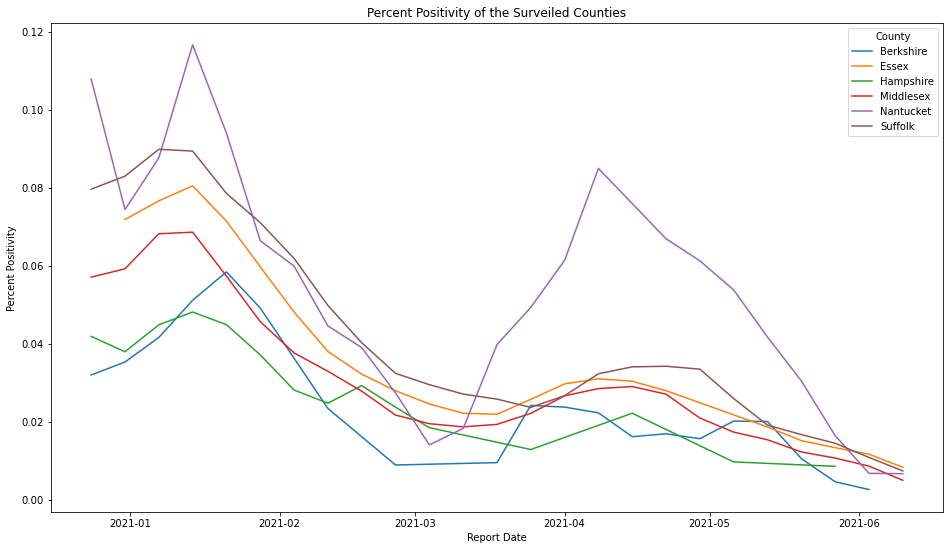

In [80]:
plt.figure(figsize=(16,9))
sns.lineplot(y='Percent Positivity', x=df['Report Date'], data=df, hue='County', ax=None, ci=None)
plt.title('Percent Positivity of the Surveiled Counties')

Some subject matter understanding of the vaccination rollouts will explain the downward trend in early 2021, and the vaccine hesitancy and resistance coupled with variants being introduced could explain the upward trends seen after March 2021.

Text(0.5, 1.0, 'Normalized Concentration of Rolling Average of Covid-19 mRNA found in Wastewater')

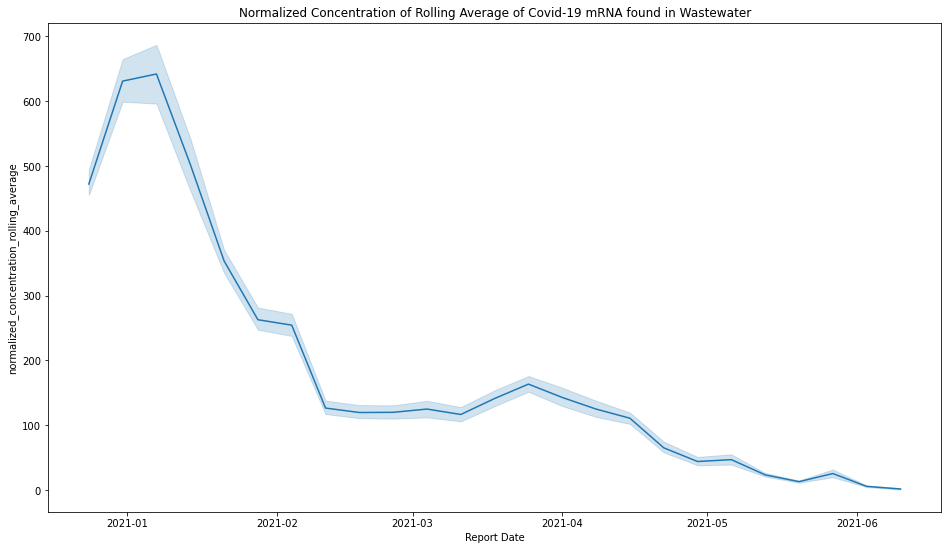

In [81]:
plt.figure(figsize=(16,9))
sns.lineplot(y='normalized_concentration_rolling_average', x=df['Report Date'], data=df)
plt.title('Normalized Concentration of Rolling Average of Covid-19 mRNA found in Wastewater')

0.44635

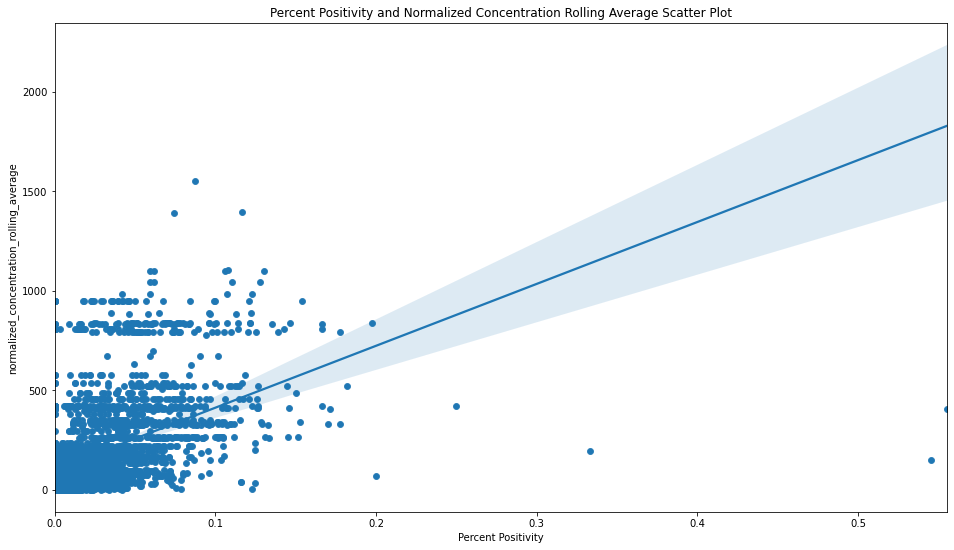

In [82]:
plt.figure(figsize=(16,9))
sns.scatterplot(data = df, x=df['Percent Positivity'], y=df.normalized_concentration_rolling_average)
sns.regplot(data = df, x=df['Percent Positivity'], y=df.normalized_concentration_rolling_average)
plt.title('Percent Positivity and Normalized Concentration Rolling Average Scatter Plot')
df.normalized_concentration_rolling_average.corr(df['Percent Positivity']).round(5)

In [83]:
test = df.copy()

## Notes to Luka for Review

The line plot seems to have some kind of time-series trend that are in tandem with each other.

Thoughts on time-series possibilities:
1. AR, MA, or ARMA models
2. Auto-correlation whilst looking at various lag values
3. Probably should test for unit root stationarity.

The scatter plots, while showing large variability, a regression line still showed some positive correlation.

What I worry about is how those outliers seen in the scatterplots may be affecting the calculated correlation coefficients. Must discuss with Luka. 

Finally, I did some preprocessing ahead of schedule to see the correlation between 'Change Since Last Week' and the 'mwra_concentration' features. Whil they aren't the strongest, concentration hass the highest rated correlation coefficient.

I think I will pursue with concentration and Change Since.

### Here are my Null and Alternate Hypothesis to test:

#### H01: The concentration of covid-19 rna in sewage does not affect either Positivity Percentage.

#### H-Alternate1: The concentration of Covid-19 rna surveilled in sewage does affect Positivity Percentage.

#### H02: The concentration of covid-19 rna in sewage does not affect Change Since Last Week
#### H-Alternate2: The concentration of Covid-19 rna surveilled in sewage does affect Change Since Last Week
#### Discuss with Luka:
Do I need to set my p-value here? Howabout the level of significance, or the power needed to support these hypotheses?

In [84]:
#Saving current df for next Capstone 2 Unit
df.to_pickle('Unit16FeatureEngineering.pkl') #Commenting out for Github commit

# Pre-processing (Unit 16.3)

## Goals from the rubric:
1. Create dummy features
2. Scale standardization
3. Split data into training and testing subsets

### Create Dummy features
I did this earlier, and will copy the commented out code here for mentor review.

After review, I don't think get_dummies was the best choice, and I'll add a integer mapping for 'Change Since' later

In [ ]:
#Converted object types into categorical dtypes
'''
def conversion(df, conversion_list):
    '''Method to convert my features into their appropriate datatypes'''
    for list in conversion_list:
        for col in list:
            if col in int64_list:
                df[col] = df[col].astype('int64')
            if col in category_list:
                df[col] = df[col].astype('category')
            if col in float64_list:
                df[col] = df[col].astype('float64')
'''
# I converted the following features:
# Color, Change Since Last Week, Change in Last Week

#Created dummy variables for thes categorical features:
# Change Since Last Week and Change in Last Week

'''
test = pd.get_dummies(df['Change Since Last Week'], prefix='Since Last Week', prefix_sep='-')
test1 = pd.get_dummies(df['Change in Last Week'], prefix='In Last Week', prefix_sep='-')
'''


#added code to integer map 'Change Since last Week'

#Merged my main df with these two dummy-added dfs
'''
test_df = df.copy()
merged_test1 = pd.merge(test_df, test, how='inner', right_index=True, left_index=True)
merged_test = pd.merge(merged_test1, test1, how='inner', right_index=True, left_index=True)
'''

# Finally I updated the main dataframe
'''
df = merged_test
'''

In [71]:
#load pickle for this unit
with open('Unit16FeatureEngineering.pkl', 'rb') as f:
    df_preprocessing = pickle.load(f)
    
df_preprocessing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   datetime64[ns]
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   category      
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   category      
 5   City/Town                                 3162 non-null   category      
 6   Percent Positivity                        3162 non-null   float64       
 7   Change Since Last Week                    3162 non-null   category      
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: category(4), datetime64[ns](

In [ ]:
#Note - I originally processed dummy variables for 'Change', but it increased the size of my dataset to 407k observations
#Later in pre-processing, I'll use sklearn's LabelEncoder to map integer values using .fit_transform()

## Addressing Stationarity:
I know it is a timeseries dataset. I have to test for stationarity with these tests:
1. Does it show a trend?
2. Does it show cyclicality or seasonality?
3. Does the variance change with time?
4. Does the dynamics change with time?

In [86]:
df_preprocessing.set_index('Report Date', inplace=True)

Let's look at 'avg_concentration' and then apply the Dicky-Fuller test.

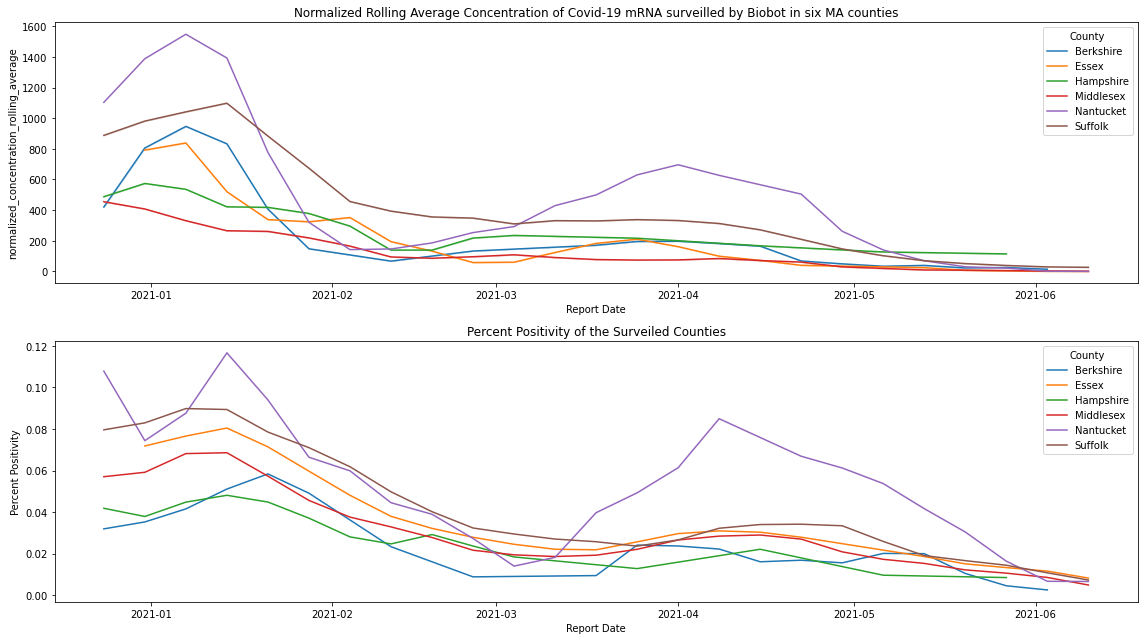

In [87]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16,9))
sns.lineplot(data=df_preprocessing, x=df_preprocessing.index, y='normalized_concentration_rolling_average', hue='County', ax=ax1)
ax1.set_title('Normalized Rolling Average Concentration of Covid-19 mRNA surveilled by Biobot in six MA counties')
                               
sns.lineplot(data=df_preprocessing, x=df_preprocessing.index, y='Percent Positivity', hue='County', ax=ax2, ci=None)
ax2.set_title('Percent Positivity of the Surveiled Counties')

plt.tight_layout()
plt.show()

Before addressing stationarity, let's compare to whitenoise. 

<AxesSubplot:>

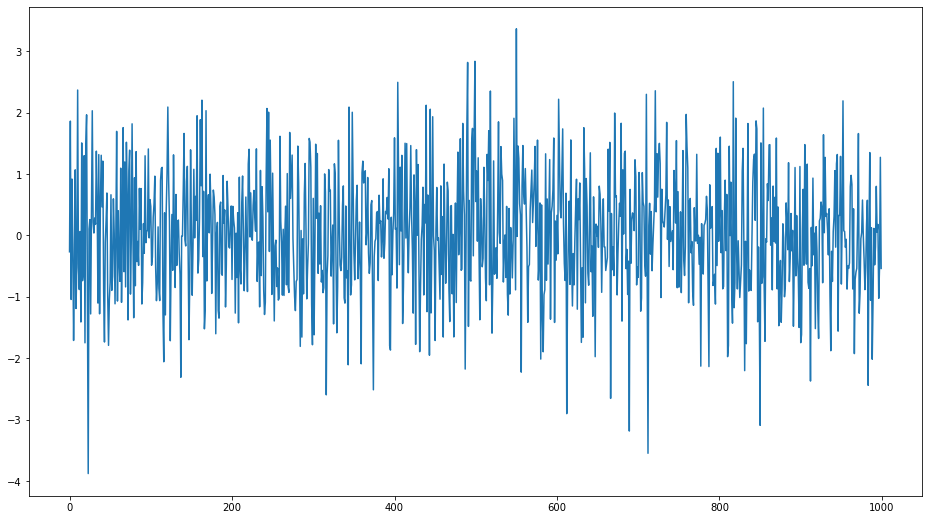

In [88]:
fig, ax = plt.subplots(figsize=(16,9))

#creating white noise using a gaussian distribution between 0 and 1 with 1000 samples
white_noise = [random.gauss(0,1) for i in range(1000)]

#casting white_noise into a Series so it may be graphed
white_noise = pd.Series(white_noise)
sns.lineplot(data=white_noise)

## We've seen normalized_concentration, Percent Positivity, and white noise. 
They look different, but let's use the Augmented Dicky-Fuller test to determine stationarity.

In [75]:
#encountered some LinAlgErrors when running Dickey-Fuller, reloaded df from pickle as df_0
with open('Unit16FeatureEngineering.pkl', 'rb') as f:
    df_0 = pickle.load(f)

df_0.set_index('Report Date', inplace=True)

<AxesSubplot:xlabel='Report Date', ylabel='normalized_concentration_rolling_average'>

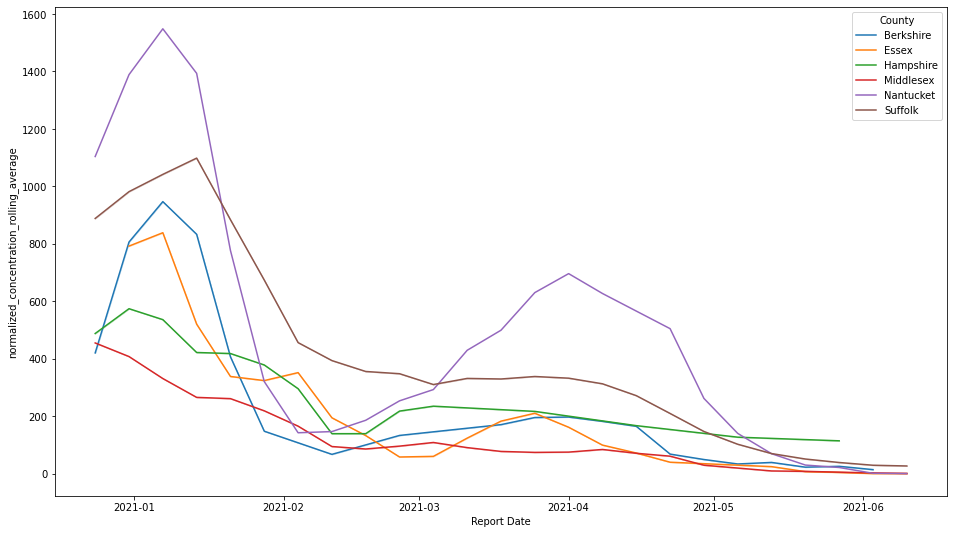

In [76]:
plt.figure(figsize=(16,9))
data = pd.DataFrame(df_0.drop_duplicates())
#print(len(data), len(df_0))
sns.lineplot(data=data, x=data.index,y=data['normalized_concentration_rolling_average'], hue='County')

In [77]:
# a LinAlgError occurred here, testing for NaNs
results = sm.tsa.stattools.adfuller(df_0['normalized_concentration_rolling_average'])
#df['normalized_concentration_rolling_average'].isnull().sum()

In [92]:
print(results)

(-3.470362199089018, 0.008781690115955018, 28, 3133, {'1%': -3.4324389453866817, '5%': -2.8624629669644266, '10%': -2.5672613171352516}, 31441.743031096827)


#### Analyzing ADF (normalized concentration rolling average)
1. first number is -3.45 (test statistic). The more negative, the more likely the set is stationary
2. second number 0.009 (test p-value). If p is small, reject H0 == reject non-stationary
3. The dictionary contains critical test statistics.

AD Fuller shows 'normalized_concentration_rolling_average' is a stationary timeseries.

### Generating the ADF score for white_noise for comparison. 
When we run ADF on white_noise we expect:
1. stationarity
2. very negative test statistic
3. low p-value.

Obviously points 2 and 3 will come with stationarity. 

In [93]:
white_noise_ADF = sm.tsa.stattools.adfuller(white_noise)
print(white_noise_ADF)

(-24.142151539669737, 0.0, 1, 998, {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573}, 2754.1556925693094)


#### As expected, a very negative test-statistic, a very low (0!) p-value. White_noise exhibits stationarity.

### Let's compare ADF on a random walk.
#### Random Walk is different than white_noise, each step is dependent on the previous value. Here's what to expect:
1. A test-statistic nearer to 0, maybe even positive. 
2. A p-value greater than 0.05
3. The graph looks like a time-series

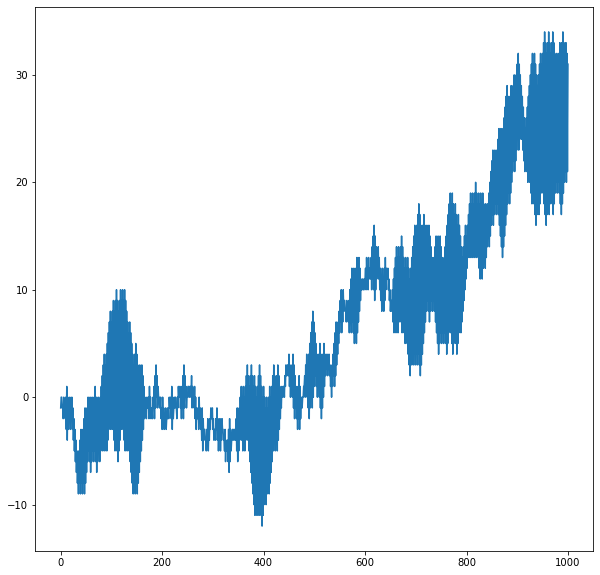

(0.2916040853708628, 0.9769559908579484, 1, 999, {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 2774.8549226193245)


In [94]:
#creating a random_walk to graph and then to compare ADF. 
#Needed some help here, found the code here:
# https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/
#import random as random # moved to beginning of notebook
random.seed(1)

random_walk = []

random_walk.append(-1 if random.random() < 0.5 else 1)
for i in range(1000):
    movement = -1 if random.random() < 0.5 else 1
    #here's the key point, the current value is a modification of the previous value [i-1]
    value = random_walk[i-1] + movement
    random_walk.append(value)
    
    
fig, ax = plt.subplots(figsize = (10,10))
sns.lineplot(data=random_walk)
plt.show()
random_walk_ADF = sm.tsa.stattools.adfuller(random_walk)
print(random_walk_ADF)

#### Random Walk shows:
1. A test statistic of 0.29 (positive and nearer to 0)
2. A p-value of 0.9769
3. Looks like a time series

With such a large p-value, we cannot reject the hypothesis that this random walk is non-stationary. It's values are dependent on the previous values. Think 'A drunkard's walk'.

### A brief note on 'Stationary Time Series'
From my studies, a stationary time series is best described as one where the values are not dependent on time.

Random walk shows non-stationarity, meaning it's values are dependent on the one before hand. 
Some features of non-stationary time series:
1. No consistent mean over time
2. No consistent variance over time

Percent Positivity and normalized_concentration_rolling_average were determined to be stationary. 

What does that mean for my project?


### A deeper look into stationarity
While the ADF may show stationarity, I need to remind myself that this is an aggregate of the six county-level data set. 
Because the goal is to forecast wastewater concentrations of Covid-19 by county, why not check for stationarity at the county level?

In [78]:
def county_ADF(df: pd.DataFrame, feature):
    '''
    A method to extract the Augmented Dicky-Fuller test values from county level data
    Params:
    df - (pd.DataFrame) with 'County' column
    feature -  (string) - the name of the feature column to test for ADF
    Returns a dictionary with:
    County -  (string) the name of the county
    ADF - (tuple) the test-statistic and p-value of that county level data
    '''
    adf_dict = {}
    for county in df.County.unique():
        adf_dict[county] = pd.DataFrame(df.loc[df['County']==county, 
                                               feature]
                                          .drop_duplicates())
        
        
    #print(adf_dict.keys())
    county_ADF = {}
    for county, df in adf_dict.items():
        adf = sm.tsa.stattools.adfuller(df[feature])
        county_ADF[county] = {'test-statistic': adf[0], 'p-value':adf[1]}
    return county_ADF


In [79]:
test_county_ADF_method = county_ADF(df_0, 'normalized_concentration_rolling_average')

In [80]:
for county in test_county_ADF_method.keys():
    print(county, test_county_ADF_method[county])

Berkshire {'test-statistic': -8.14872810372554, 'p-value': 9.826948680796276e-13}
Essex {'test-statistic': -1.5389302303555474, 'p-value': 0.5141728049273325}
Hampshire {'test-statistic': -1.1417617418031638, 'p-value': 0.6981338694357283}
Middlesex {'test-statistic': -1.7064520585626328, 'p-value': 0.4277912857757429}
Nantucket {'test-statistic': 0.005477996686873882, 'p-value': 0.9589827747521857}
Suffolk {'test-statistic': -3.030362872805752, 'p-value': 0.032154544360425225}


### The Point:
This process of determining stationarity is germane to determining whether there is structure in the data.
If structure exists then we can learn something from that time series.

Some counties have stronger negative test-statistics (Berkshire) and very significant p-values (Berkshire, again).

Others aren't as negative nor are their p-values showing statistical significance towards rejecting non-stationarity.

By showing that normalized_concentration at the county level is non-stationary it necessitates pre-processing before any 
insightful modelling can be done. 

## County-level specific dataframes
It has become obvious that I need the granularity of county-specific data without coding up the slice everytime

In [81]:
#creating a county:df mapped dictionary for convenience
county_dict = {}
for county in df_0.County.unique(): 
    county_dict[county] = pd.DataFrame(df_0.loc[df_0.County==county, 
                                       ['County', 'normalized_concentration_rolling_average']]
                                      )
    county_dict[county].drop_duplicates(inplace=True)


In [82]:
test = county_dict['Berkshire']
county_ADF(test, 'normalized_concentration_rolling_average')

{'Berkshire': {'test-statistic': -8.14872810372554,
  'p-value': 9.826948680796276e-13}}

### Preprocessing for stationarity.
I'd like to test how preprocessing the entire dataset will affect the county-level ADF's too.

In [103]:
import scipy.stats as stats
#this is the unprocessed control
control_stationarity = county_ADF(df_0, 'normalized_concentration_rolling_average')


#conducting a yeo-johnson transformation, and testing to see if it changes at the county level
yeo_test = df_0.copy()
yeo_test = yeo_test.loc[:, ['County', 'normalized_concentration_rolling_average']].drop_duplicates()
transform_to_yeo = yeo_test.normalized_concentration_rolling_average.values

data=stats.yeojohnson(transform_to_yeo) #returns in a list of [array, maxlog]
yeo_test['yeo'] = data[0]
yeo_test.drop(columns='normalized_concentration_rolling_average', inplace=True)
yeo_test_stationarity = county_ADF(yeo_test, 'yeo')

In [104]:
for county in df_0.County.unique():
    print(county+' Control: ', control_stationarity[county], 
      '\n'+county+' Yeo-Johnson Test: ', yeo_test_stationarity[county],'\n')

Berkshire Control:  {'test-statistic': -8.14872810372554, 'p-value': 9.826948680796276e-13} 
Berkshire Yeo-Johnson Test:  {'test-statistic': 2.2803686628948885, 'p-value': 0.9989423731414838} 

Essex Control:  {'test-statistic': -1.5389302303555474, 'p-value': 0.5141728049273325} 
Essex Yeo-Johnson Test:  {'test-statistic': 2.062551894591108, 'p-value': 0.9987489178471907} 

Hampshire Control:  {'test-statistic': -1.1417617418031638, 'p-value': 0.6981338694357283} 
Hampshire Yeo-Johnson Test:  {'test-statistic': -1.4992445105074585, 'p-value': 0.5338850356001192} 

Middlesex Control:  {'test-statistic': -1.7064520585626328, 'p-value': 0.4277912857757429} 
Middlesex Yeo-Johnson Test:  {'test-statistic': 0.15940463490148302, 'p-value': 0.9698905745425836} 

Nantucket Control:  {'test-statistic': 0.005477996686873882, 'p-value': 0.9589827747521857} 
Nantucket Yeo-Johnson Test:  {'test-statistic': 2.8713916164521933, 'p-value': 1.0} 

Suffolk Control:  {'test-statistic': -3.030362872805752

### Yeo-Johnson Transformation made it worse!
Try for Box-Cox Power Transformation

In [105]:
#conducting a yeo-johnson transformation, and testing to see if it changes at the county level
boxcox_test = df_0.copy()
box_negative_filter = (boxcox_test['normalized_concentration_rolling_average'] ==0)
boxcox_test = boxcox_test.loc[~box_negative_filter, ['County', 'normalized_concentration_rolling_average']].drop_duplicates()
transform_to_box = boxcox_test.normalized_concentration_rolling_average.values

data=stats.boxcox(transform_to_box) #returns in a list of [array, maxlog]
boxcox_test['boxcox'] = data[0]
boxcox_test.drop(columns='normalized_concentration_rolling_average', inplace=True)
boxcox_test_stationarity = county_ADF(boxcox_test, 'boxcox')

for county in df_0.County.unique():
    print(county+' Control: ', control_stationarity[county], 
      '\n'+county+' Box-Cox Test: ', boxcox_test_stationarity[county],'\n')

Berkshire Control:  {'test-statistic': -8.14872810372554, 'p-value': 9.826948680796276e-13} 
Berkshire Box-Cox Test:  {'test-statistic': 2.407089492460328, 'p-value': 0.9990136070097886} 

Essex Control:  {'test-statistic': -1.5389302303555474, 'p-value': 0.5141728049273325} 
Essex Box-Cox Test:  {'test-statistic': 212.11147250766982, 'p-value': 1.0} 

Hampshire Control:  {'test-statistic': -1.1417617418031638, 'p-value': 0.6981338694357283} 
Hampshire Box-Cox Test:  {'test-statistic': -1.4871275081840876, 'p-value': 0.5398692943223813} 

Middlesex Control:  {'test-statistic': -1.7064520585626328, 'p-value': 0.4277912857757429} 
Middlesex Box-Cox Test:  {'test-statistic': 1.6033452044333374, 'p-value': 0.9978675770838004} 

Nantucket Control:  {'test-statistic': 0.005477996686873882, 'p-value': 0.9589827747521857} 
Nantucket Box-Cox Test:  {'test-statistic': 1.9115039584898343, 'p-value': 0.9985463041184205} 

Suffolk Control:  {'test-statistic': -3.030362872805752, 'p-value': 0.032154

### Same with Box-Cox
Did not make the county-level data any more stationary.
Try differencing.

I took some time off at this point to review how to transform time-series to something more stationary.
I continued with the differencing portion when I progressed into the ARIMA pre-processing.

I did attempt to revert back to predicting the 'Change Since Last Week' feature using the following sklearn models:
1. RandomForest
2. LogisticRegression

Here is my attempt.

# Modelling a predictor

## Label Encoding 'Change Since Last Week'
Tried get_dummies and OrdinalEncoder too.

In [106]:
from sklearn.preprocessing import LabelEncoder

#Initializing
label_encoder = LabelEncoder()
data = pd.DataFrame(df_preprocessing['Change Since Last Week'])

label = label_encoder.fit_transform(data)
print(label)


[1 2 0 ... 1 1 1]


C:\Users\Aim\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [107]:
print(label[:5], df_preprocessing['Change Since Last Week'].head())

[1 2 0 0 1] Report Date
2020-12-24        Lower
2020-12-24    No Change
2020-12-24       Higher
2020-12-24       Higher
2020-12-24        Lower
Name: Change Since Last Week, dtype: category
Categories (3, object): ['Higher', 'Lower', 'No Change']


### 'Label' Map:
A gentle reminder I used LabelEncoder() on 'Change Since Last Week' and saved it as 'Label'. Here is how it was mapped:

'Higher': 0

'Lower':1

'No Change': 2

## Partitioning the train, test set

In [108]:
df_preprocessed2 = df_preprocessing.copy()
df_preprocessed2['Change Since Last Week'] = label


y = pd.DataFrame(df_preprocessed2[['County', 'City/Town', 'Change Since Last Week']])

#There's a more pythonic way to slice this using idiomatic pandas
#df[df.columns.difference(['excluded column'])] #should utilize this from now on
X = pd.DataFrame(df_preprocessed2[[x for x in df_preprocessed2.columns if x!='Change Since Last Week']])

#Changing the categorical columns into codes for the model
X['County_code'] = X.County.cat.codes
X['City_code'] = X['City/Town'].cat.codes
X['Population_code'] = X.population.cat.codes

X = X.drop(columns=['per', 'sampling_week'])



In [109]:
y['City/Town'].unique()

['Adams', 'Alford', 'Becket', 'Cheshire', 'Clarksburg', ..., 'Nantucket', 'Boston', 'Chelsea', 'Revere', 'Winthrop']
Length: 145
Categories (145, object): ['Adams', 'Alford', 'Becket', 'Cheshire', ..., 'Boston', 'Chelsea', 'Revere', 'Winthrop']

### Here's something I missed in DataWrangling!
Because the Mass_df is from Massachusetts DoH, they have the trends for all the cities in MA. But biobot only has a subset of these cities contained in the six counties they surveilled! 

The crux of my problem is my lack of surveillance data on all these cities. Wrangle!

In [111]:
#Run this to see that .sort_index will not solve the issue of redundant index datetime values
#Note how there are multiple 2020-12-24 obsevations, because its from different cities!
X.sort_index()

,normalized_concentration_rolling_average,population,County,City/Town,Percent Positivity,County_code,City_code,Population_code
Report Date,,,,,,,,
2020-12-24,4.200423e+02,50000-100000,Berkshire,Adams,0.028758,0,1,4
2020-12-24,4.547221e+02,100000-200000,Middlesex,Shirley,0.106326,3,111,1
2020-12-24,4.547221e+02,100000-200000,Middlesex,Sherborn,0.046422,3,110,1
2020-12-24,4.547221e+02,100000-200000,Middlesex,Reading,0.056667,3,99,1
2020-12-24,4.547221e+02,100000-200000,Middlesex,Pepperell,0.075949,3,95,1
...,...,...,...,...,...,...,...,...
2021-06-10,9.947598e-14,20000-50000,Essex,Wenham,0.000000,1,131,2
2021-06-10,9.947598e-14,20000-50000,Essex,Topsfield,0.002755,1,121,2
2021-06-10,9.947598e-14,20000-50000,Essex,Swampscott,0.001242,1,119,2


In [112]:
from sklearn.model_selection import TimeSeriesSplit
#Here's how I Wrangled the city-level data. Used a dictionary
#k:v are city:partitioned set
#where partitioned set are [X_train, X_test, y_train, y_test]

city_partition_dict = {}
for city in X['City/Town'].unique():
    X_new = pd.DataFrame(X.loc[X['City/Town']==city, :]
                        ).drop(columns=
                               ['population', 'County', 'City/Town']
                              ).sort_index()
    y_new = pd.DataFrame(y.loc[y['City/Town']==city, 'Change Since Last Week']).sort_index()
    
    #manually coded the train/test split with test_size = 0.2
    X_train = X_new[int(X_new.shape[0]*0.2):]
    X_test = X_new[:int(X_new.shape[0]*0.2)]
    y_train = y_new[int(y_new.shape[0]*0.2):]
    y_test = y_new[:int(y_new.shape[0]*0.2)]
    
    #Train_test_split doesn't work because it ruins the time-series sequence.
    #X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.10)
    city_partition_dict[city] = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test}

    


### It's Wrangled again. 
And I partitioned it to boot! (20% test_size)

#### Where I goofed:
The assumption on the partition is that it needed to be of a uniform ratio. I used 8:2 train:test.

The issue with this assumption is that it is not only the ratio, but the size of the partition must be similar as well. This mis-step on my assumption led to my inability to model KNN on all the cities in my dataset. Lesson learned.

Now I have a dictionary where the k:v is:
k: The name of the city
v: four items:
1. X_train
2. X_test
3. y_train
4. y_test

In [113]:
Adams = city_partition_dict['Adams']

In [114]:
Adams['X_train']

,normalized_concentration_rolling_average,Percent Positivity,County_code,City_code,Population_code
Report Date,,,,,
2021-01-21,406.299685,0.044966,0,1,4
2021-01-28,147.432108,0.031579,0,1,4
2021-02-11,66.858163,0.038375,0,1,4
2021-02-25,132.755118,0.006878,0,1,4
2021-03-18,170.369244,0.002841,0,1,4
2021-03-25,195.137153,0.010568,0,1,4
2021-04-01,196.736261,0.031215,0,1,4
2021-04-08,181.796497,0.040541,0,1,4
2021-04-15,164.592287,0.035635,0,1,4


## Let's try some Classification models

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [119]:
#Defining the partitions from Adams
X_train,X_test,y_train,y_test = Adams['X_train'],Adams['X_test'],Adams['y_train'],Adams['y_test']

In [120]:
#Instantiating the models
rf_model = RandomForestClassifier()
SVC_model = SVC()
KNN_model = KNeighborsClassifier(n_neighbors=3)
naive_bayes_model = GaussianNB()

In [121]:

y_train_ravel = np.ravel(y_train)

SVC_model.fit(X_train, y_train_ravel)
KNN_model.fit(X_train, y_train_ravel)
rf_model.fit(X_train, y_train_ravel)
naive_bayes_model.fit(X_train, y_train_ravel)

GaussianNB()

In [122]:
SVC_pred = SVC_model.predict(X_test)
KNN_pred = KNN_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
nb_pred = naive_bayes_model.predict(X_test)

## We Modeled; let's see how it scored

In [123]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [125]:
print('SVC: ',accuracy_score(SVC_pred, y_test))
print('KNN: ', accuracy_score(KNN_pred, y_test))
print('RandomForest: ', accuracy_score(rf_pred, y_test))
print('Naive Bayes: ', accuracy_score(nb_pred, y_test))

SVC:  0.25
KNN:  0.75
RandomForest:  0.25
Naive Bayes:  0.25


In [126]:
print(confusion_matrix(SVC_pred, y_test))
print(classification_report(KNN_pred, y_test))

[[0 0]
 [3 1]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.00      0.00      0.00         0

    accuracy                           0.75         4
   macro avg       0.50      0.38      0.43         4
weighted avg       1.00      0.75      0.86         4



C:\Users\Aim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
print(classification_report(rf_pred, y_test))

              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.00      0.00      0.00         2

    accuracy                           0.25         4
   macro avg       0.17      0.25      0.20         4
weighted avg       0.17      0.25      0.20         4



In [128]:
print(classification_report(nb_pred, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.25      0.40         4

    accuracy                           0.25         4
   macro avg       0.50      0.12      0.20         4
weighted avg       1.00      0.25      0.40         4



C:\Users\Aim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aim\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Here is my attempt to run KNN on all the cities data
I comment out this cell because the error code is lengthy, but I learned a lot from this attempt.
The error lies in the fact that my partition of train/test splits are not of the same size for 
city in my dictionary. I have not solved this issue yet.



KNN_score_dict = {}
for city in city_partition_dict.keys():
    
    X_train=city_partition_dict[city].get('X_train')
    X_test=city_partition_dict[city].get('X_test')
    y_train=city_partition_dict[city].get('y_train')
    y_test=city_partition_dict[city].get('y_test')
    
    y_test_ravel = np.ravel(y_test)
    
    instantiating the model
    knn_model = KNeighborsClassifier(n_neighbors=3)
    knn_model.fit(X_train,y_train_ravel)
    knn_pred = knn_model.predict(X_test)
    
    #Storing accuracy score into dictionary
    KNN_score_dict[city] = accuracy_score(knn_pred, y_test)


# Supervised learning Summary -*Where Capstone 2 Grading SHOULD END*
My rudimentary foray into predicting 'Changes Since Last Week' has come to an end.
My most 'accurate' model was the KNearestNeighbors. It's accuracy was 75%. In no way should that be used to really predict the trend in Covid-19 surges.

If I had more time, here is how I would expand on this project:
1. learn how to partition datasets where the size of the set is inconsistent
2. Apply GridSearchCV on my models to see if it improves
3. Apply hyper parameters to see if any improvements
4. Apply gradient boosting to account for my perceived small dataset

### What I learned in my attempt:
1. Data can be 'crappy', pun intended. Learned how to wrangle.
2. Before merging/joining datasets together, I need to understand the features in each set.
3. Visual EDA; I enjoy seaborn very much

This second point is key, because without this understanding I did not know how the new set would expand in size, leading to a very hard time understanding the issues created by the 'City/Town' and its linear combination with the 'normalized_concentration' feature. 

3. Time Series.

# Time Series - Oh, boy!
What led me down the rabbit hole was my encounter of this time-series data. Unfortunately I could not delve completely into everything introduced by my mentor. Here's where I'm still in the dark:
1. Windowing function

Here's where I gave my all:
1. Understanding Stationarity
2. Understanding Distribution
3. Creating ARIMA models

Here is where I think I messed up:
1. I plowed through the ARIMA pre-processing and modelling sections applying transformations and the auto_arima() function on the entire dataset.
2. I think my forgetting about the county level granularity may have impeded rapid progress.

### What do I mean by granularity?

Testing ADF on the whole data set does not match when I test ADF for county-specific measurements.

I spent way too much time in my attempt to learn time-series analysis. 
Whilst grotesquely incomplete, the cells beneath this will document my attempt to forecast (note, not predict) the wastewater surveillance number using the best p,d,q parameters found through the pmdarima model. Reader beware, it is not well-kept in terms of what was documented above.

# The Ol' College Try: Time Series modelling

### Let's try ARIMA Move this somewhere down the line - NS
I want to forecast the 'Change Since Last Week', Massachusett's determination of the trend of Covid-19 infections. 
I tried 

From my understanding of the data, I cannot confidently say that this time-series is Univariate. However to document my learning, I have chosen to proceed with forecasting based on the time series.

I have chosen the ARIMA model. ARIMA stands for 'Auto Regressive Integrated Moving Average'. It's based on the idea that information from the past values of the time-series can alone be used to forecast future values.

ARIMA is characterized by three terms:
1. 'p' is the order of the Auto Regressive term
2. 'q' is the order of the Moving Average term
3. 'd' is the number of differencing required to make the time series stationary

### Addressing stationarity (redux)
Earlier I ran the augmented Dickey-Fuller test to test for stationarity. The results allowed me to accept the hypothes that normalized_concentration_rolling_average is non-stationary, for the most part.

To review: some counties showed acceptable stationarity in their set, but many others did not. I posit whether the size of the dataset had to do with that?

I learned that applying power transformations (Box-Cox and Yeo-Johnson) to the dataset affects the ADF scores on when focused on the county-level data. I ASSUME that by applying any further transformations to my overall dataset (df_0), I will not only see a more stationary score on the whole set, but also on the county level.

Let's look at differencing the normalized_concentration, plotting the Auto Correlation function, and see if we can derive a stationary time-series.

#### Note: The following code was inspired from
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

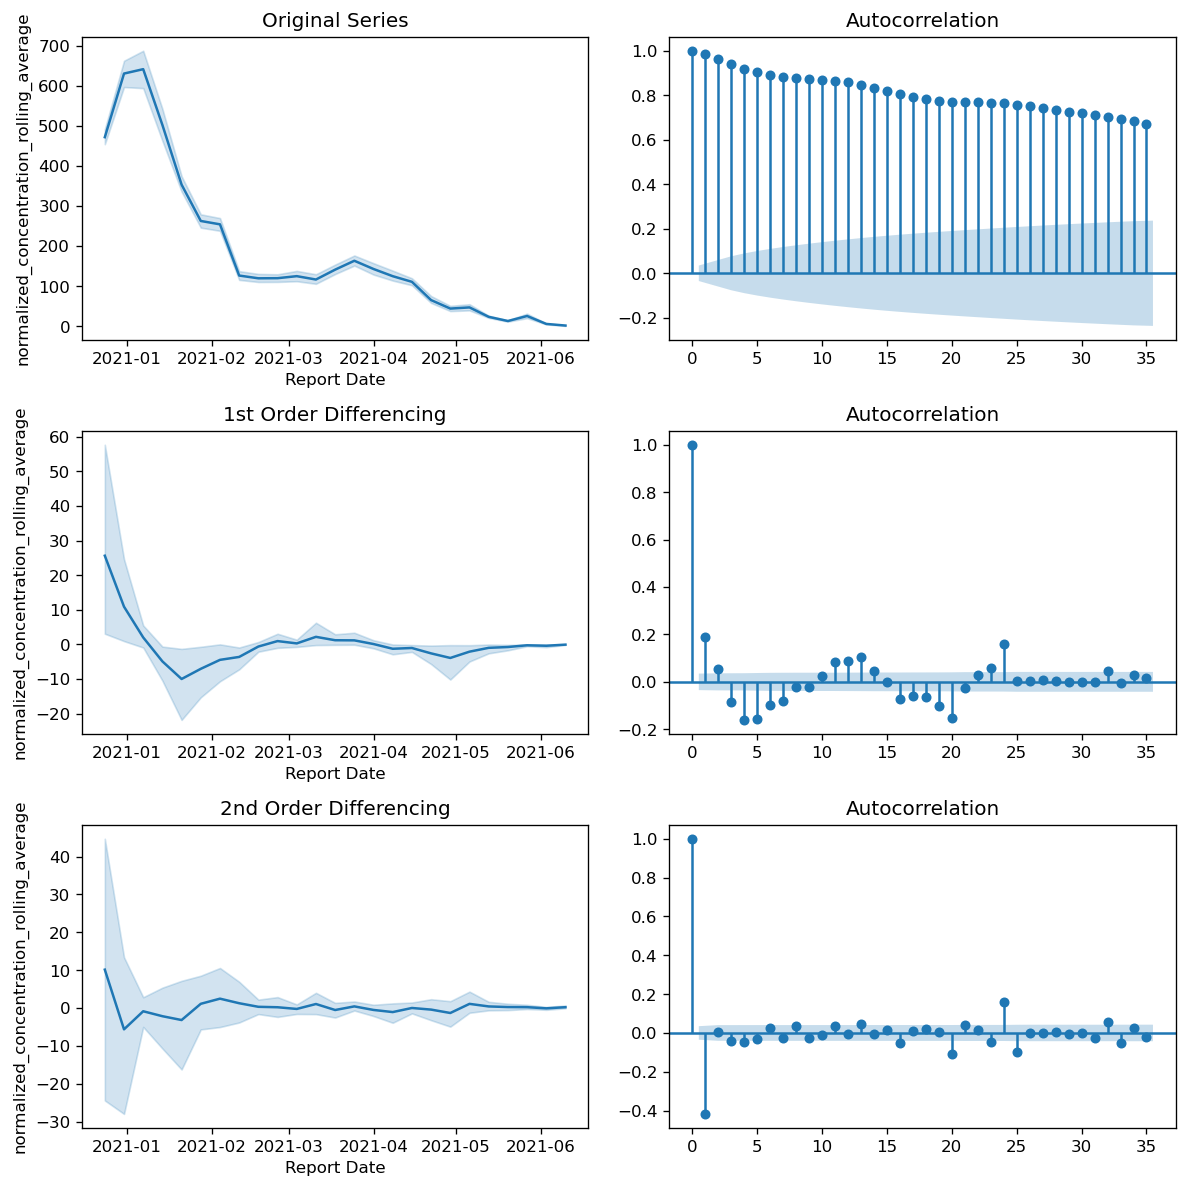

In [129]:
plt.rcParams.update({'figure.figsize':(10,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
sns.lineplot(data=df_0, x= df_0.index, 
             y = df_0['normalized_concentration_rolling_average'], 
             ax=axes[0,0])
axes[0, 0].set_title('Original Series')
plot_acf(df_0['normalized_concentration_rolling_average'], ax=axes[0, 1])

# 1st Differencing
sns.lineplot(data=df_0, x=df_0.index, 
             y=df_0['normalized_concentration_rolling_average'].diff(), 
             ax=axes[1,0])
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_0['normalized_concentration_rolling_average'].diff().dropna(), 
         ax=axes[1, 1])

# 2nd Differencing
sns.lineplot(data=df_0, x=df_0.index, 
             y=df_0['normalized_concentration_rolling_average'].diff().diff(), 
             ax=axes[2,0])
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_0['normalized_concentration_rolling_average'].diff().diff().dropna(), 
         ax=axes[2, 1])

plt.tight_layout()
plt.show()

In [130]:
# testing the ADF values for 1st and 2nd Order Differencing. 
first_order_diff = pd.Series(df_0['normalized_concentration_rolling_average'].diff().dropna())
second_order_diff = pd.Series(df_0['normalized_concentration_rolling_average'].diff().diff().dropna())

first_order_ADF = sm.tsa.stattools.adfuller(first_order_diff)
second_order_ADF = sm.tsa.stattools.adfuller(second_order_diff)

In [131]:
print(first_order_ADF[:2])

(-12.35112126353084, 5.822388419030004e-23)


In [132]:
print(second_order_ADF[:2])

(-20.513698433742277, 0.0)


In [133]:
print(sm.tsa.stattools.adfuller(df_0['normalized_concentration_rolling_average']))

(-3.470362199089018, 0.008781690115955018, 28, 3133, {'1%': -3.4324389453866817, '5%': -2.8624629669644266, '10%': -2.5672613171352516}, 31441.743031096827)


In [134]:
yt = df_0['normalized_concentration_rolling_average']
yt1 = df_0['normalized_concentration_rolling_average'].shift(1)
first_shift = pd.Series(yt-yt1).drop_duplicates()
first_shift.dropna(inplace=True)
print(sm.tsa.stattools.adfuller(first_shift))

(-6.39530520250568, 2.0578431872402093e-08, 7, 123, {'1%': -3.4846672514209773, '5%': -2.8853397507076006, '10%': -2.5794629869786503}, 1552.2062425261165)


## What I learned:
1. Shifting and .diff()'ing are different
2. .diff() is calculus where you take an integral of formula

Here is a good guide: https://towardsdatascience.com/all-the-pandas-shift-you-should-know-for-data-analysis-791c1692b5e

### Stronger Stationarity
The ACF plots show stronger stationarity in both 1st and 2nd order differencing. 

This is confirmed when testing with ADF, where both features more negative test statistics and smaller p-values than the normalized_concentration series. 


Here's where I have to choose.

The normalized_concentration has been tested and confirmed to be non-stationary. For the time-series, differencing makes it stationary. What I have to be careful is with overfitting the differencing. I am unsure if that is what is happening with the 2nd Order Differencing, as the p-value is 0 and ACF plots at lag-1 is negative. I fear as I saw such a p-value during my ADF test of white_noise, this may be the case.

I choose d= 1.

## Reviewing AR and MA models and defining the ARIMA model
A pure AR model is one where the forecasted value depends only on its lags.

A pure MA model is where the forecasted value depends only on the lagged forecast errors.

The error terms are the errors of the AR models of the respective lags.

The ARIMA model is where the time series was differenced at least once to make it stationary, and combines the AR and MA terms.

In words:

"Predicted Value = Constant + Linear combination Lags of Y (up to p lags) + Linear Combination of Lagged forecast errors (up to q lags)"

## Something to keep in mind:
I know I reference p,d,q terms for the ARIMA model, but an easier way to remember is:
p = AR
d = I
q = MA

Instead of thinking 'p,d,q' terms, think 'AR, I, MA' terms!

### The question at hand is what is the right order of differencing?
I used this resource to better understand differencing: 

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

The right order is the MINIMUM differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick. 

The original series shows an ACF plot where the plotted lags do not reach zero at all. This is not differenced enough for ARIMA.

The 1st order (d=1) shows a plot where the lags reaches zero.
The 2nd order shows the lag-1 autocorrelation is too negative. I believe this is over-differenced.

I choose to define the right order of differencing as d=1. 

### How to find the order of the AR term (p)?
Look at the partial autocorrelation plot (PACF). 
PACF is imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags.

It sort of conveys the pure correlation between the lag and the series - I will know if that lag is needed in the AR term or not. 

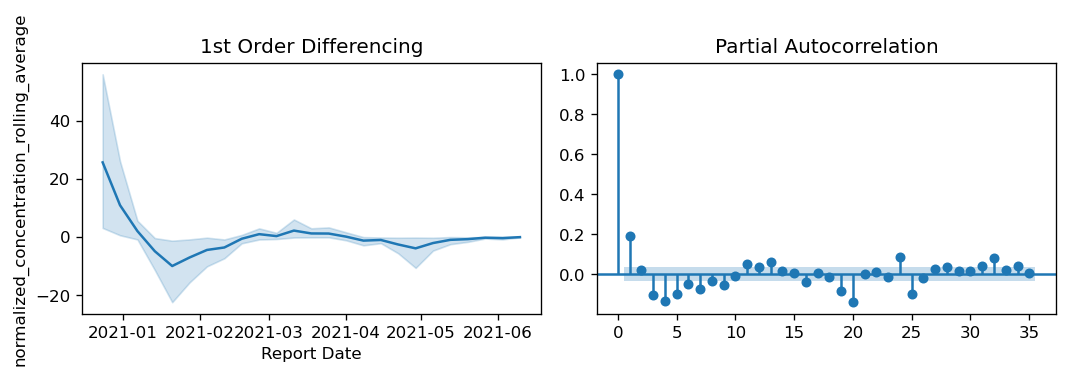

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))

sns.lineplot(data=df_0, x=df_0.index, 
             y=df_0['normalized_concentration_rolling_average'].diff(), ax=axes[0])
axes[0].set_title('1st Order Differencing')
plot_pacf(df_0['normalized_concentration_rolling_average'].diff().dropna(), ax=axes[1])
plt.tight_layout()
plt.show()

In the partial autocorrelation (PACF) graph, the shaded blue area indicates the significance line. I see that the lag-1 value is quite significant as it is well above said line. Lag-2 is already within that line. 

Due to the PACF plot, I choose AR order of one; p=1.

### How to find the order of the MA term (q)?

I've already seen the autocorrelation of the 1st order differencing. But let's review it.

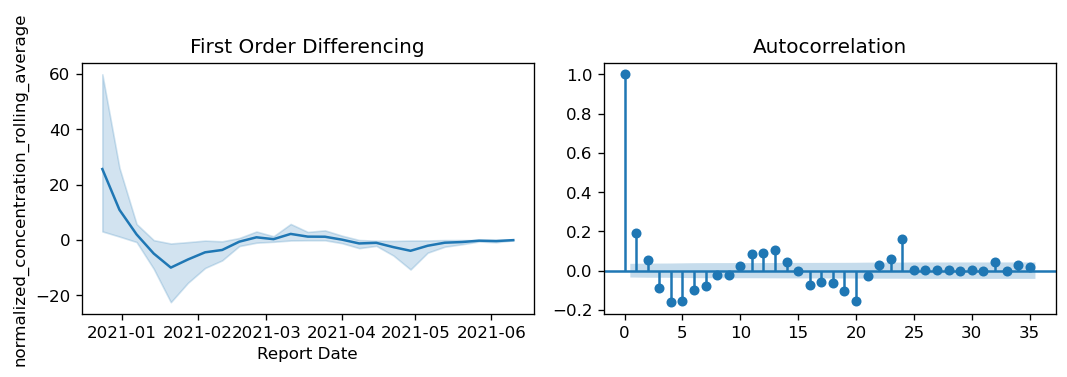

In [136]:
#rehasing the ACF plot for 1st order differencing. 

fig, axes = plt.subplots(1,2, figsize=(9,3))
sns.lineplot(data=df_0, x=df_0.index,
             y=df_0['normalized_concentration_rolling_average'].diff(), ax=axes[0])
axes[0].set_title('First Order Differencing')
plot_acf(df_0['normalized_concentration_rolling_average'].diff().dropna(), ax=axes[1])
plt.tight_layout()
plt.show()

#### The ACF plot shows that lags 1 and 2 are above the significance line. 

I choose MA order of 2; q=2

## ARIMA Model
I have the three ARIMA terms:
1. For the differencing: d = 1
2. For the Auto Regression: p = 1
3. For the Moving Average q = 2

Let's go. 

####  Error Warning:
statsmodels.tsa.arima_model is being deprecated, but I haven't delved into the SARIMAX replacement yet. I don't understand the math, so I'll silence the deprecation warning and soldier on with ARIMA for now.

In [137]:

# Silencing the ARIMA deprecation warning

warnings.filterwarnings('ignore') 

#ARIMA takes the pdq params in (p, d, q) order

#1, 1, 2 ARIMA model
#before submitting work, change df name to something more explicity - NS 8.20.21
df = pd.DataFrame(df_0['normalized_concentration_rolling_average'])
model = ARIMA(df.values, order=(1,1,2))
model_fit_112 = model.fit()
print(model_fit_112.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3161
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -15979.788
Method:                       css-mle   S.D. of innovations             37.953
Date:                Wed, 25 Aug 2021   AIC                          31969.576
Time:                        12:57:52   BIC                          31999.869
Sample:                             1   HQIC                         31980.443
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1227      0.462     -0.266      0.790      -1.028       0.782
ar.L1.D.y      0.8375      0.026     32.412      0.000       0.787       0.888
ma.L1.D.y     -0.6983      0.028    -25.139      0.0

### How to read this:
The middle table is the coefficients table. Values under 'coef' are the weights of the respective terms. 

P-values are under the P>|z| column.
1. MA2 is very significant
2. MA1 does is greater than p=0.05, so it is not significant

AIC, the Akaike Information Criteria, is a score for comparing models. The lower the better.
Here the AIC is huge (31978.713). 

Let's see if we can rebuild ARIMA to yield a lower AIC score.

In [138]:
# 1,1,1 ARIMA Model
model = ARIMA(df.values, order=(1,1,1))
model_fit_111 = model.fit()
print(model_fit_111.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3161
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -15997.654
Method:                       css-mle   S.D. of innovations             38.168
Date:                Wed, 25 Aug 2021   AIC                          32003.308
Time:                        12:58:04   BIC                          32027.542
Sample:                             1   HQIC                         32012.002
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1245      0.846     -0.147      0.883      -1.782       1.533
ar.L1.D.y      0.2346      0.061      3.829      0.000       0.115       0.355
ma.L1.D.y     -0.0466      0.062     -0.757      0.4

In [139]:
# 1,1,3 ARIMA Model
model = ARIMA(df.values, order=(1,1,3))
model_fit_113 = model.fit()
print(model_fit_113.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3161
Model:                 ARIMA(1, 1, 3)   Log Likelihood              -15946.449
Method:                       css-mle   S.D. of innovations             37.554
Date:                Wed, 25 Aug 2021   AIC                          31904.897
Time:                        12:58:05   BIC                          31941.249
Sample:                             1   HQIC                         31917.938
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1228      0.461     -0.267      0.790      -1.025       0.780
ar.L1.D.y      0.7399      0.033     22.642      0.000       0.676       0.804
ma.L1.D.y     -0.5960      0.035    -17.261      0.0

Just by fudging with the p,d,q values I can see a lowered AIC (1,1,3 model), but with the 1,1,1 model the p-value too high, making the MA feature insignificant. 

Using the same logic as a grid search, I think it is possible to computationally find an ARIMA model with the lowest AIC and significant p-values.

But first! Let's look at the residuals to see whether or not patterns exists. Paterns could be:
1. Constant mean
2. Constant variance

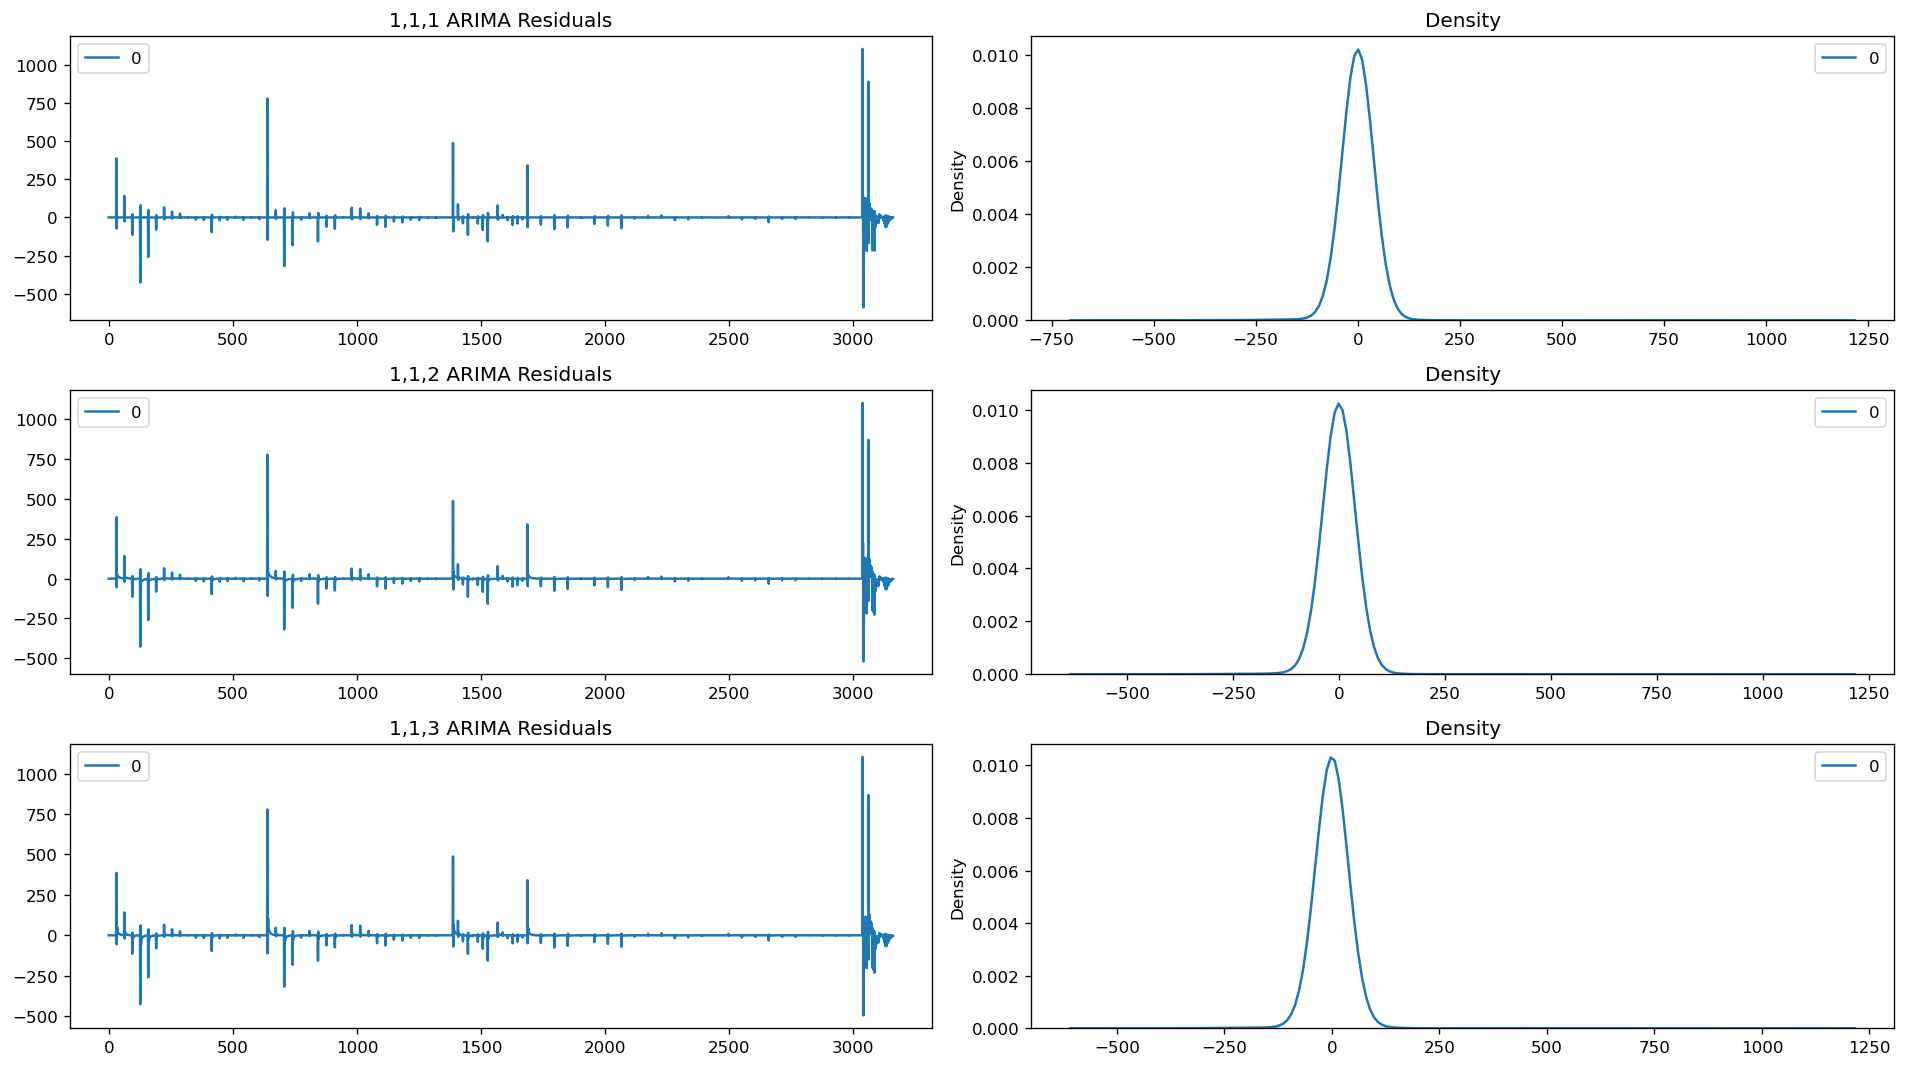

In [140]:
#graphing the residuals from the three ARIMA models
residuals111 = pd.DataFrame(model_fit_111.resid)
residuals112 = pd.DataFrame(model_fit_112.resid)
residuals113 = pd.DataFrame(model_fit_113.resid)
fig, ax = plt.subplots(3,2, figsize=(16,9), sharex=False)
#1,1,1 set
ax[0,0].set_title('1,1,1 ARIMA Residuals')
sns.lineplot(data=residuals111, ax=ax[0,0])
ax[0,1].set_title('Density')

#A kernel density plot is used here
#KDE is a non-parametric estimate, meaning we don't need to know the data's distribution 
#while not knowing the distribution, we can still construct a probability density function!
#if I didn't stipulate the bandwith param 'bw', my plot would be a spike
#the higher the bw param, the smoother my curve

#from this video: https://www.youtube.com/watch?v=N8TfVBmCVu8
#'The smaller the bandwidth, the more detail we want to see'
sns.kdeplot(data=residuals111, ax=ax[0,1], bw=1)

#1,1,2 set
sns.lineplot(data=residuals112, ax=ax[1,0])
ax[1,0].set_title('1,1,2 ARIMA Residuals')
sns.kdeplot(data=residuals112, ax=ax[1,1], bw=1)
ax[1,1].set_title('Density')

#1,1,3 set
sns.lineplot(data=residuals113, ax=ax[2,0])
ax[2,0].set_title('1,1,3 ARIMA Residuals')
sns.kdeplot(data=residuals113, ax=ax[2,1], bw=1)
ax[2,1].set_title('Density')
plt.tight_layout()
plt.show()

In the residuals, I can't say I see patterns. But the that variance distribution is very dense near 0.

Let's try plotting the actuals against the fitted values.

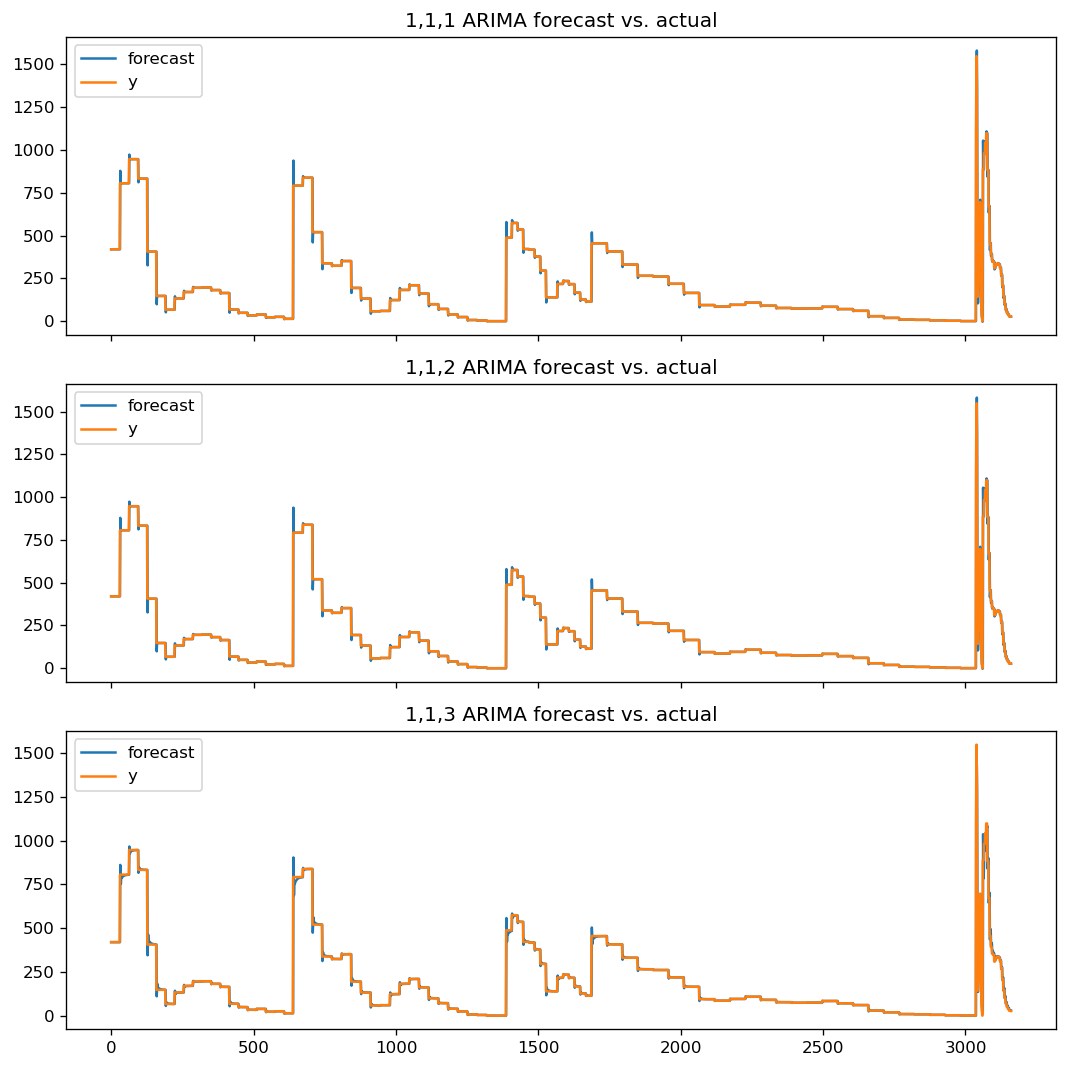

In [141]:
#Actual vs. Fitted
#when setting the param dynamic=False, the in-sample lagged values are used for the prediction
fig, axes = plt.subplots(3, 1, figsize=(9,9), sharex=True)
model_fit_111.plot_predict(dynamic=False, ax=axes[0])
axes[0].set_title('1,1,1 ARIMA forecast vs. actual')

model_fit_111.plot_predict(dynamic=False, ax=axes[1])
axes[1].set_title('1,1,2 ARIMA forecast vs. actual')

model_fit_113.plot_predict(dynamic=False, ax=axes[2])
axes[2].set_title('1,1,3 ARIMA forecast vs. actual')

plt.tight_layout()
plt.show()

In [142]:
def county_ACF(df: pd.DataFrame, county: pd.Series, wanted_feature: str):
    if wanted_feature == None:
        wanted_feature = 'normalized_concentration_rolling_average'
    else: 
        #wanted_feature = "'" + wanted_feature + "'"
        print(wanted_feature)
    data = pd.DataFrame(df.loc[df.County==county, wanted_feature].drop_duplicates())
    #Setting up the figure and axes
    fig, axes = plt.subplots(3, 2, sharex=False)
    fig.dpi==120
    
    # Original Series
    sns.lineplot(data=data, x= data.index, 
             y = data[wanted_feature], 
             ax=axes[0,0])
    axes[0, 0].set_title(county+' County Original Series')
    plot_acf(data[wanted_feature], ax=axes[0, 1])

    # 1st Differencing
    sns.lineplot(data=data, x= data.index, 
             y = data[wanted_feature].diff(), 
             ax=axes[1,0])
    axes[1, 0].set_title(county+' County 1st Order Differencing')
    plot_acf(data[wanted_feature].diff().dropna(), ax=axes[1, 1])

    # 2nd Differencing
    sns.lineplot(data=data, x= data.index, 
             y = data[wanted_feature].diff().diff(), ax=axes[2,0])
    axes[2, 0].set_title(county+' County 2nd Order Differencing')
    plot_acf(data[wanted_feature].diff().diff().dropna(), ax=axes[2, 1])

    plt.tight_layout()
    plt.show()

In [143]:
#I understand some of the formating doesn't comply with PEP8. Oh well.
def counties_ACF(df: pd.DataFrame, order: int):
    '''
    A method to plot side-by-side a lineplot and the ACF for all the counties in the dataframe.
    Parameters:
    df: Pandas DataFrame with a County column
    order: the lag value, integer from 0 onwards
    '''

    #print(type(function), str(function[0]))
    #print(' county Auto Correlation' if function == 'plot_acf' else ' county PACF')
    county_list = []
    county_dict = {}
    wanted_feature = 'normalized_concentration_rolling_average'
    yaxislabel = 'norm. concentration'

    for County in df.County.unique():
        
        #Aim, this is what you spent weeks understanding! There are duplicated dates in the index
        #the duplication is from the multiple cities in the same county
        #You HAVE to drop duplicates
        #print(County, '- total duplicated observations:',
        #      df.loc[df.County==County, wanted_feature].duplicated().sum())
        data = pd.DataFrame(df.loc[df.County==County, wanted_feature].drop_duplicates())
        county_dict[County] = data

    fig, axes = plt.subplots(len(county_dict.keys()), 2, sharey=False)

    for counter, (county, df) in enumerate(county_dict.items()):
        if order == 0: 
            axes[counter,0].set_title(county + ' county Original Series')
            sns.lineplot(data=df, x=df.index, y=df[wanted_feature], 
                         ax=axes[counter,0])
            plot_acf(df[wanted_feature], ax=axes[counter, 1])
            
        else: 
            axes[counter,0].set_title(county  + ' county '
                                      + str(order)
                                      + ' order difference')
            
            #This gets really redundant, but I can't find a way to programtically add .diff() for stipulated order
            if order == 1:
                sns.lineplot(data=df, x=df.index, 
                             y=df[wanted_feature].diff(), ax=axes[counter,0])
                plot_acf(df[wanted_feature].diff().dropna(), ax=axes[counter, 1])
            if order == 2:
                sns.lineplot(data=df, x=df.index, 
                             y=df[wanted_feature].diff().diff(), ax=axes[counter,0])
                plot_acf(df[wanted_feature].diff().diff().dropna(), ax=axes[counter, 1])
            if order == 3:
                sns.lineplot(data=df, x=df.index, 
                             y=df[wanted_feature].diff().diff().diff(), ax=axes[counter,0])
                plot_acf(df[wanted_feature].diff().diff().diff().dropna(), ax=axes[counter, 1])
            if order > 3:
                print('No way Jose, quit while you are ahead')
                
        
        axes[counter,0].set(ylabel=yaxislabel)

    plt.tight_layout()
    plt.show()

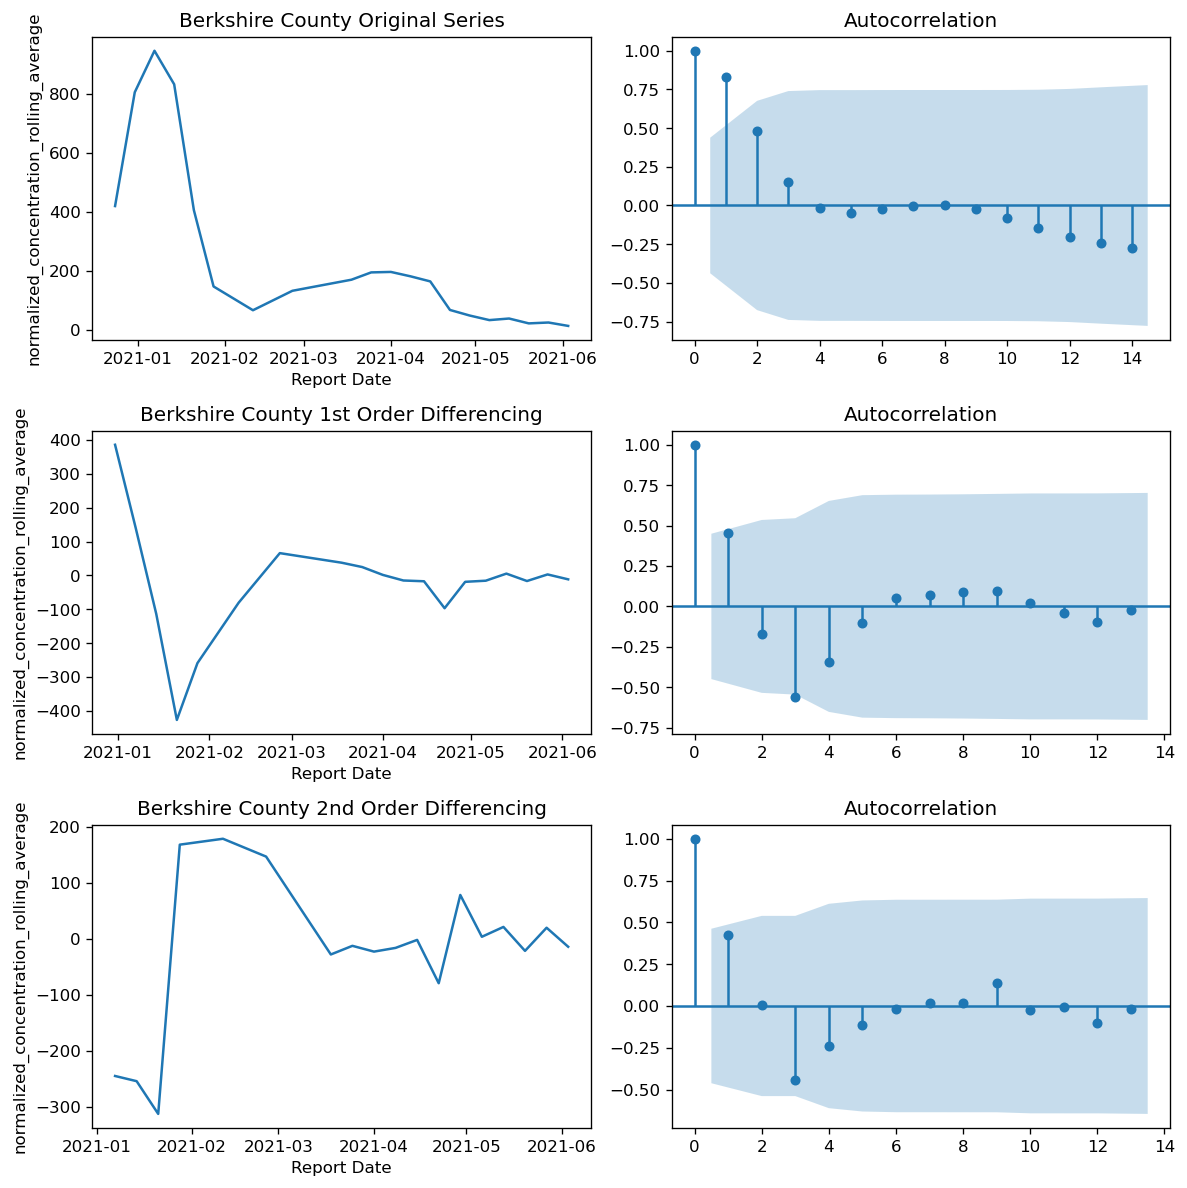

In [144]:
county_ACF(df_0, 'Berkshire', None)

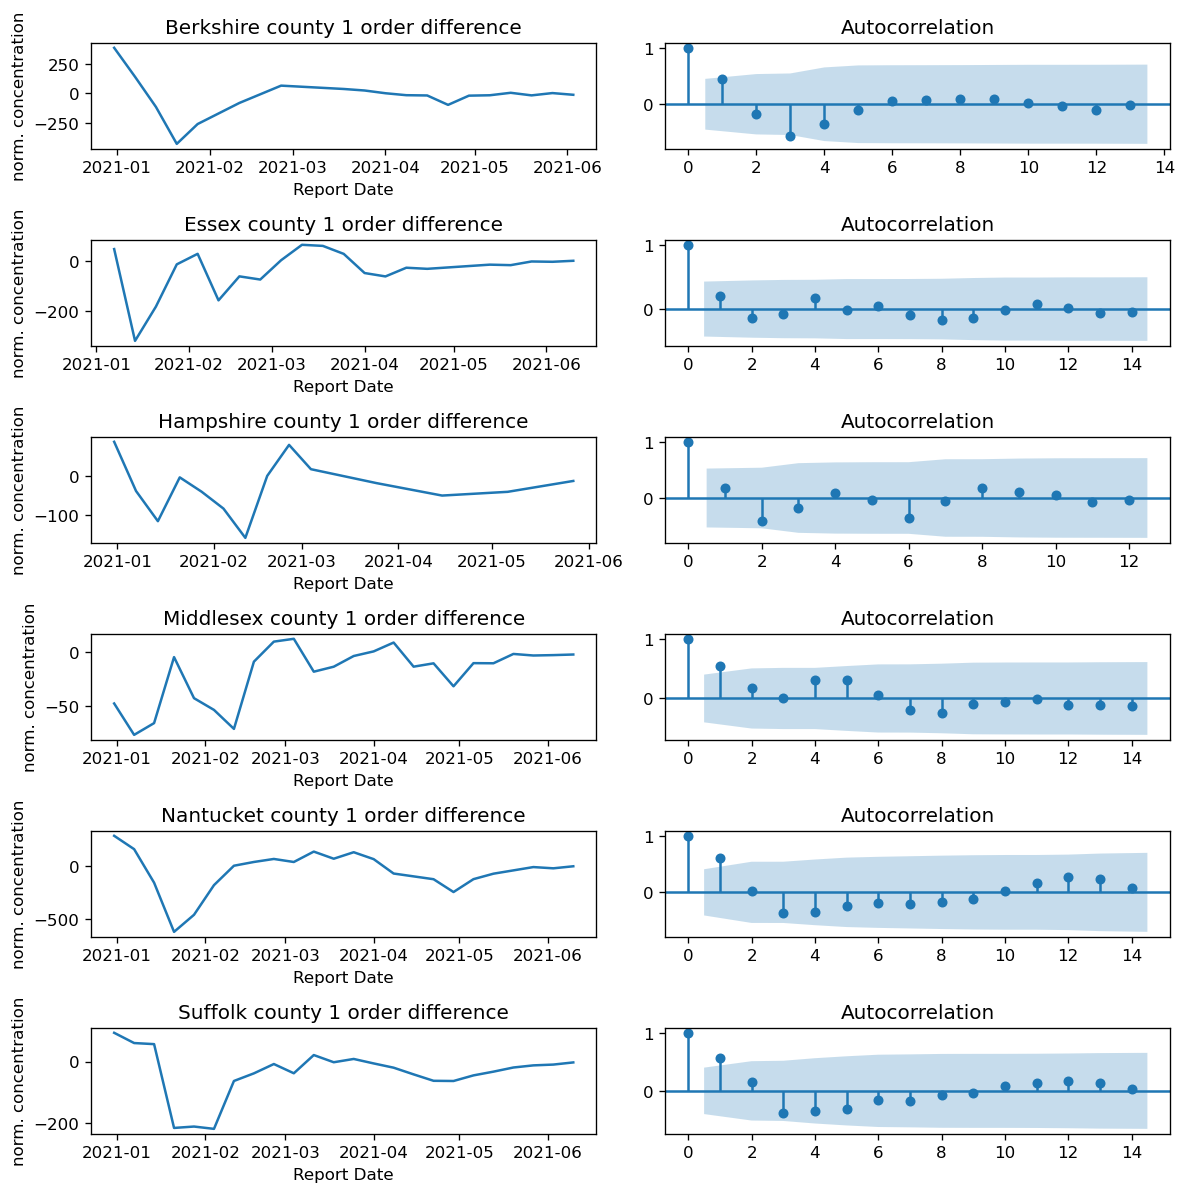

In [145]:
counties_ACF(df_0, 1)

### I did the ARIMA modelling on the entire dataset, but I know now that there are significant differences between the overall dataset and when  you focus into County-level data. I'm going to see how this difference persists in the County-level data, starting with ADF and then ARIMA and go from there.

## County-level ADF and ARIMA
I'll be focusing on Middlesex county for these reasons:
1. One of my original dataset is Cambridge's wastewater surveillance conducted by Biobot. 
2. While Cambridge data isn't normalized_concentration_rolling_average, there may be reason to use it later.
3. Cambridge is part of Middlesex county.

In [146]:
#A constant reminder that there are duplicates within the county data (from the cities within that County) 
# must drop_duplicates()!
Middlesex = pd.DataFrame(df_0.loc[df_0['County']=='Middlesex', 
                                  'normalized_concentration_rolling_average'].drop_duplicates())

### Startling how different it is.
1. Crit value isn't that negative
2. p-value is not significant at all


Let's see (graphically first) if differencing Cambridge allows for better ADF values.

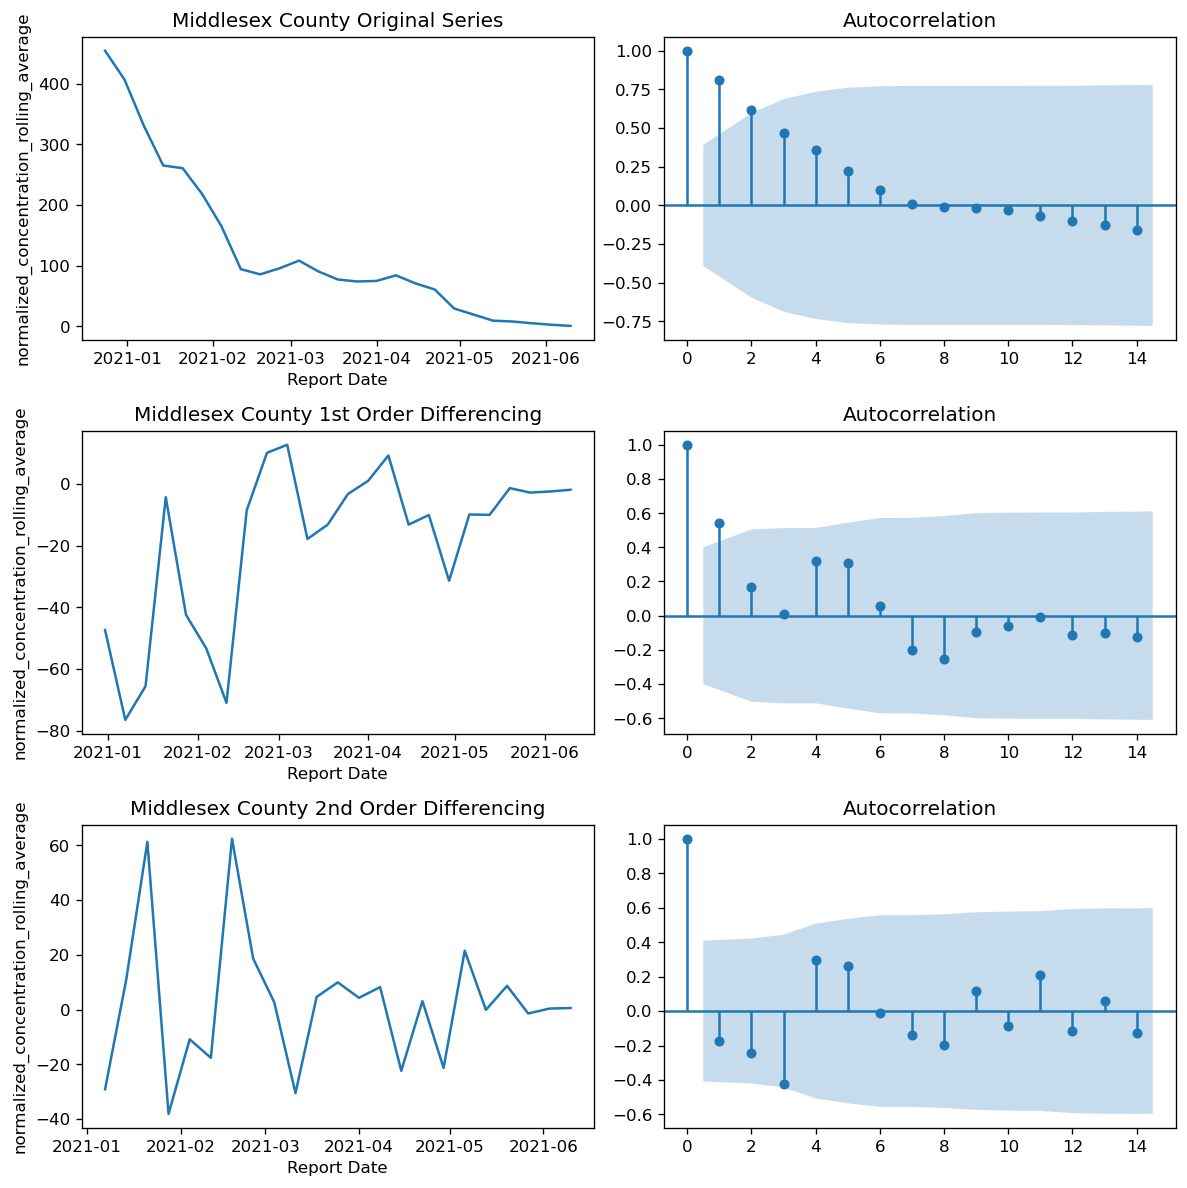

In [147]:
county_ACF(df_0, 'Middlesex', None)

In [148]:
Middlesex_ADF = sm.tsa.stattools.adfuller(Middlesex['normalized_concentration_rolling_average'])
Middlesex_first_order = sm.tsa.stattools.adfuller(Middlesex['normalized_concentration_rolling_average']
                                                  .diff()
                                                  .dropna())
Middlesex_second_order = sm.tsa.stattools.adfuller(Middlesex['normalized_concentration_rolling_average']
                                                  .diff()
                                                  .diff()
                                                  .dropna())
Middlesex_third_order = sm.tsa.stattools.adfuller(Middlesex['normalized_concentration_rolling_average']
                                                  .diff()
                                                  .diff()
                                                  .diff()
                                                  .dropna())
#Printing the test stat and p-values
print('Original: ', Middlesex_ADF[:2], '\n', 
      'First Order Differencing: ', Middlesex_first_order[:2], '\n', 
      'Second Order Differencing: ', Middlesex_second_order[:2], '\n', 
      'Third Order Differencing: ', Middlesex_third_order[:2])

Original:  (-1.7064520585626328, 0.4277912857757429) 
 First Order Differencing:  (-4.706567082276423, 8.179458108509737e-05) 
 Second Order Differencing:  (-2.2419173459994304, 0.19138499102185375) 
 Third Order Differencing:  (-1.0193491750783565, 0.7461418811413996)


First order differencing yields the most negative test-statistic and the smallest p-value (8.179 x 10^-5). 

For Middlesex, I choose a d=1 value. Onto p, use PACF.

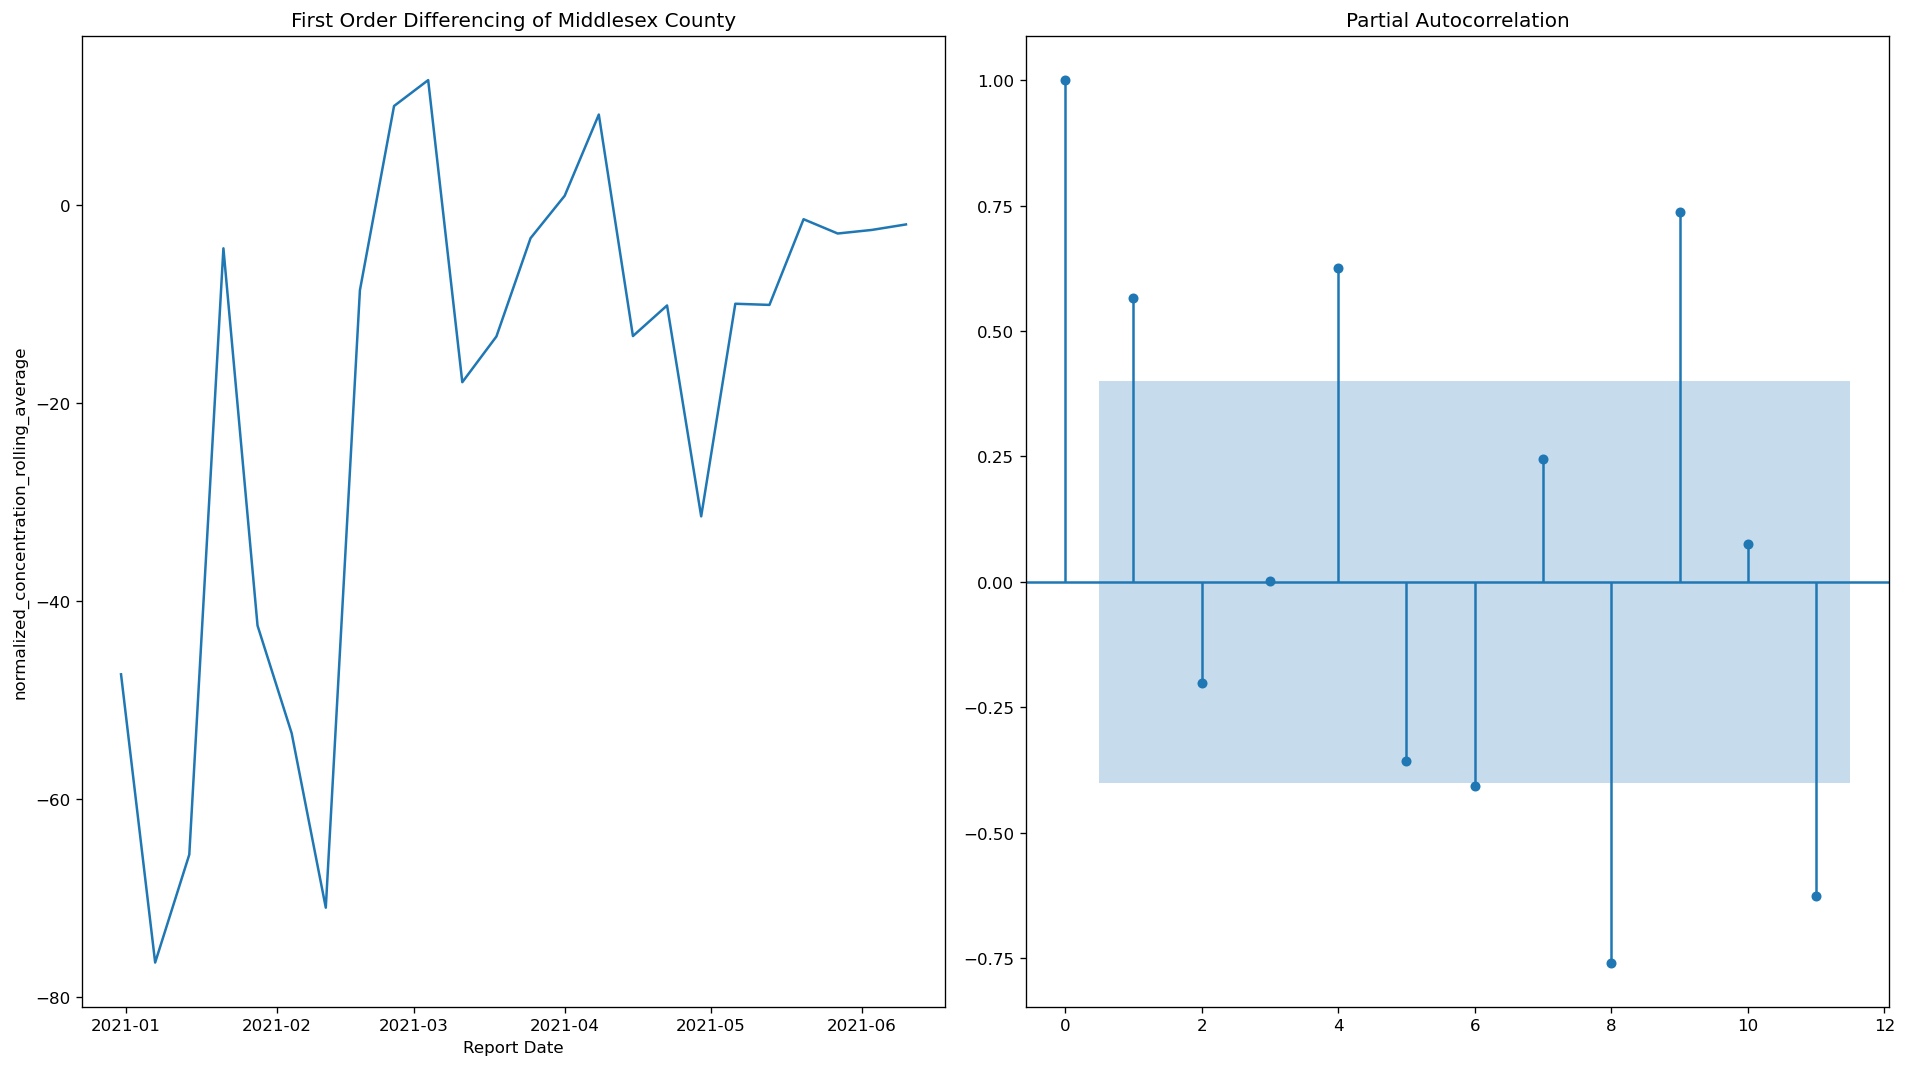

In [149]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))
pacf_test = Middlesex['normalized_concentration_rolling_average']
#mean = pacf_test.diff().describe()[1]
ax[0].set_title('First Order Differencing of Middlesex County')
sns.lineplot(data= pacf_test, x= pacf_test.index, y = pacf_test.diff(), ax=ax[0])
#ax[0].axhline(mean, color='red', label='mean')

#note to myself, because the county dataset is small (12-14nobs), I have to set lags < 50% of nobs.
plot_pacf(pacf_test.diff().dropna(), lags=((pacf_test.shape[0]//2)-1), ax=ax[1])
plt.tight_layout()
plt.show()

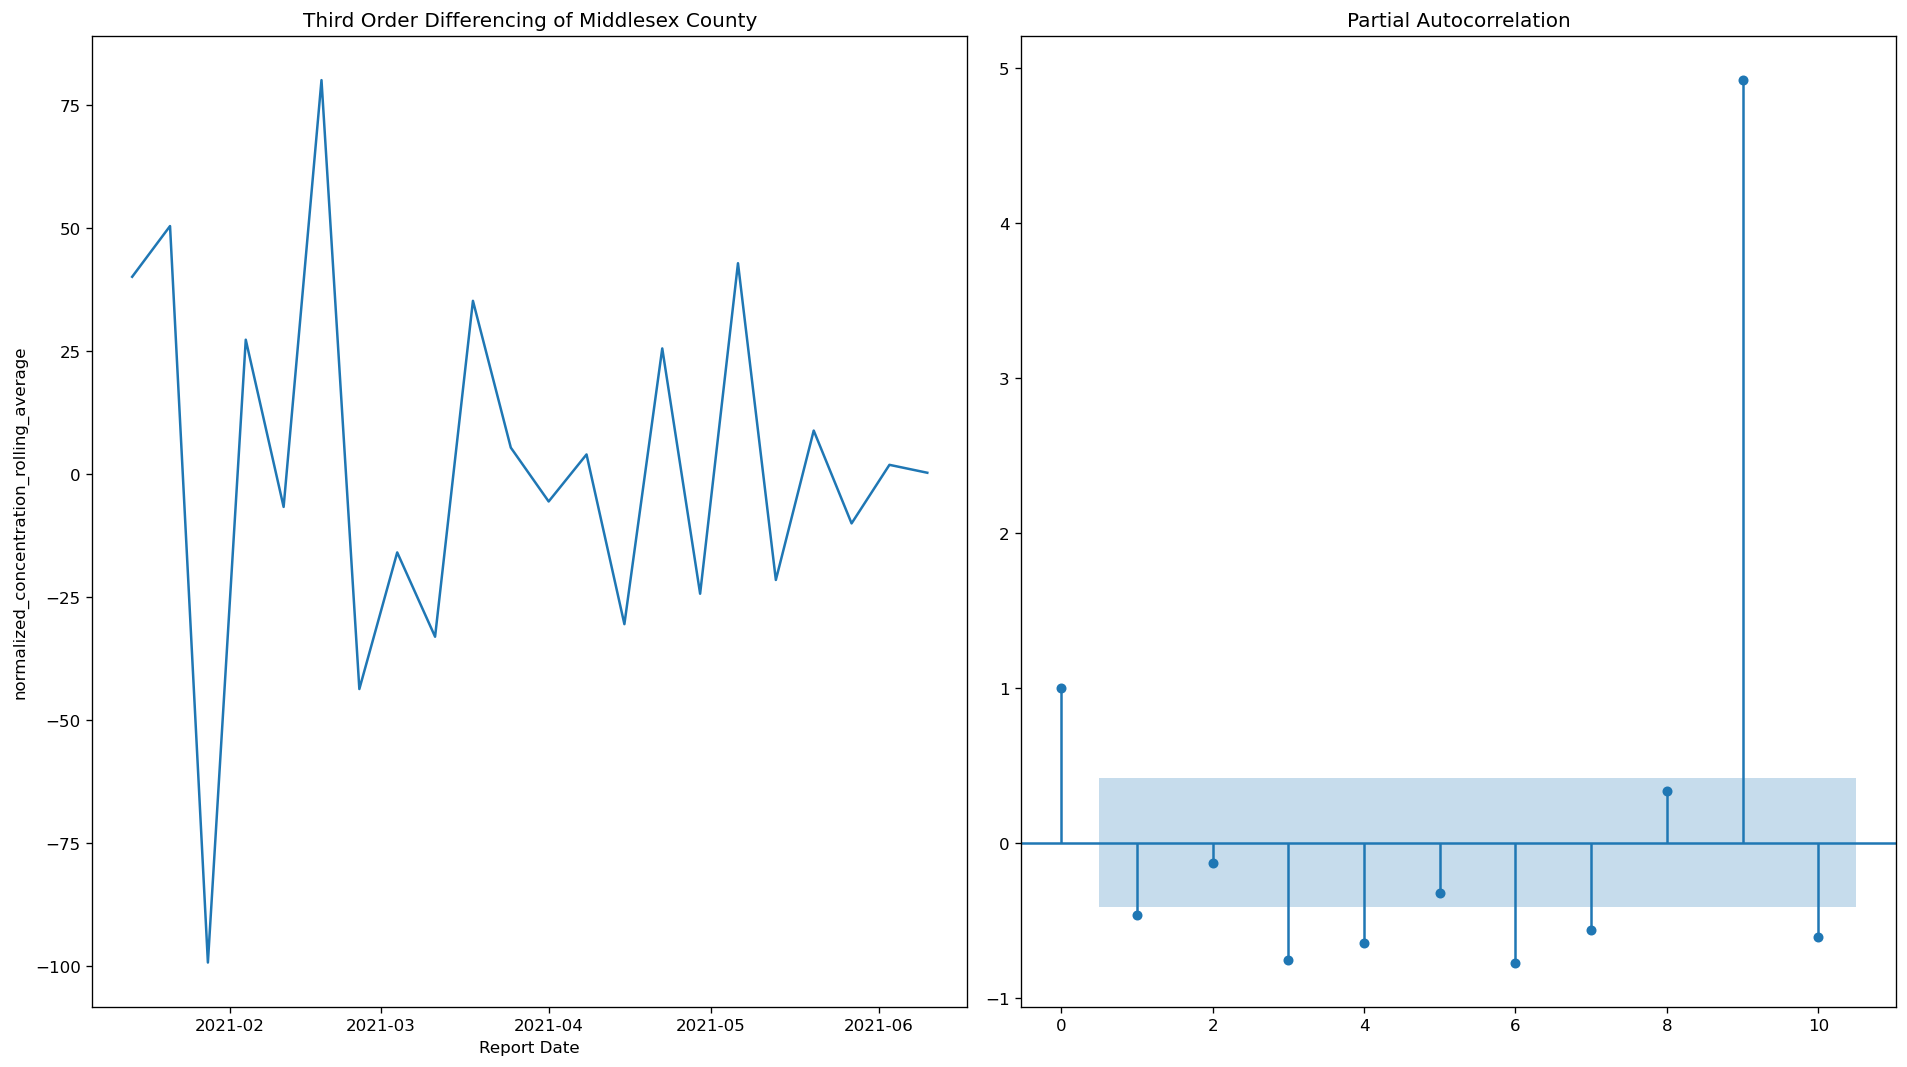

In [150]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))
ax[0].set_title('Third Order Differencing of Middlesex County')
sns.lineplot(data= pacf_test, x= pacf_test.index, 
             y = pacf_test.diff().diff().diff(), 
             ax=ax[0])
#ax[0].axhline(mean, color='red', label='mean')

#note to myself, because the county dataset is small (12-14nobs), I have to set lags < 50% of nobs.
plot_pacf(pacf_test.diff().diff().diff().dropna(), 
          lags=((pacf_test.shape[0]//2)-2), 
          ax=ax[1])
plt.tight_layout()
plt.show()

d=1, and possibly p=1.

I already ran plot_ACF for Middlesex above, and for the chosen d=1 (1st order differencing) the lag-1 value was above
the significance area. 

So, for Middlesex ARIMA let's start off with a 1, 1, 1 model

### Middlesex ARIMA:

In [151]:
# 1,1,1 ARIMA Model
Middlesex_model = ARIMA(Middlesex.values, order=(1,1,1))
Middlesex_model_fit = Middlesex_model.fit()
print(Middlesex_model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   24
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -112.019
Method:                       css-mle   S.D. of innovations             25.752
Date:                Wed, 25 Aug 2021   AIC                            232.038
Time:                        12:59:51   BIC                            236.750
Sample:                             1   HQIC                           233.288
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.9279      5.256     -3.601      0.000     -29.230      -8.625
ar.L1.D.y      1.0000      0.047     21.415      0.000       0.908       1.092
ma.L1.D.y     -1.0000      0.001  -1785.189      0.0

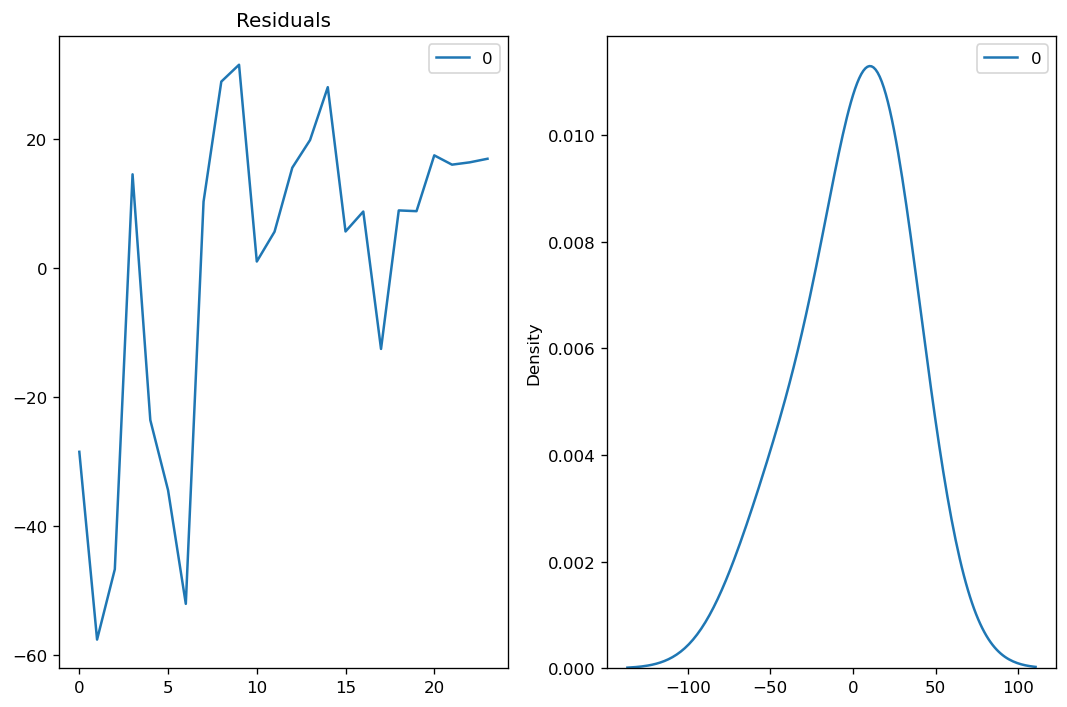

In [152]:
#Plotting 1,1,1 ARIMA residuals and looking at the Kernel Density
Middlesex_residuals = pd.DataFrame(Middlesex_model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(9,6))
Middlesex_residuals.plot(title='Residuals', ax=ax[0])
sns.kdeplot(data=Middlesex_residuals, bw=1, ax=ax[1])
plt.tight_layout()
plt.show()

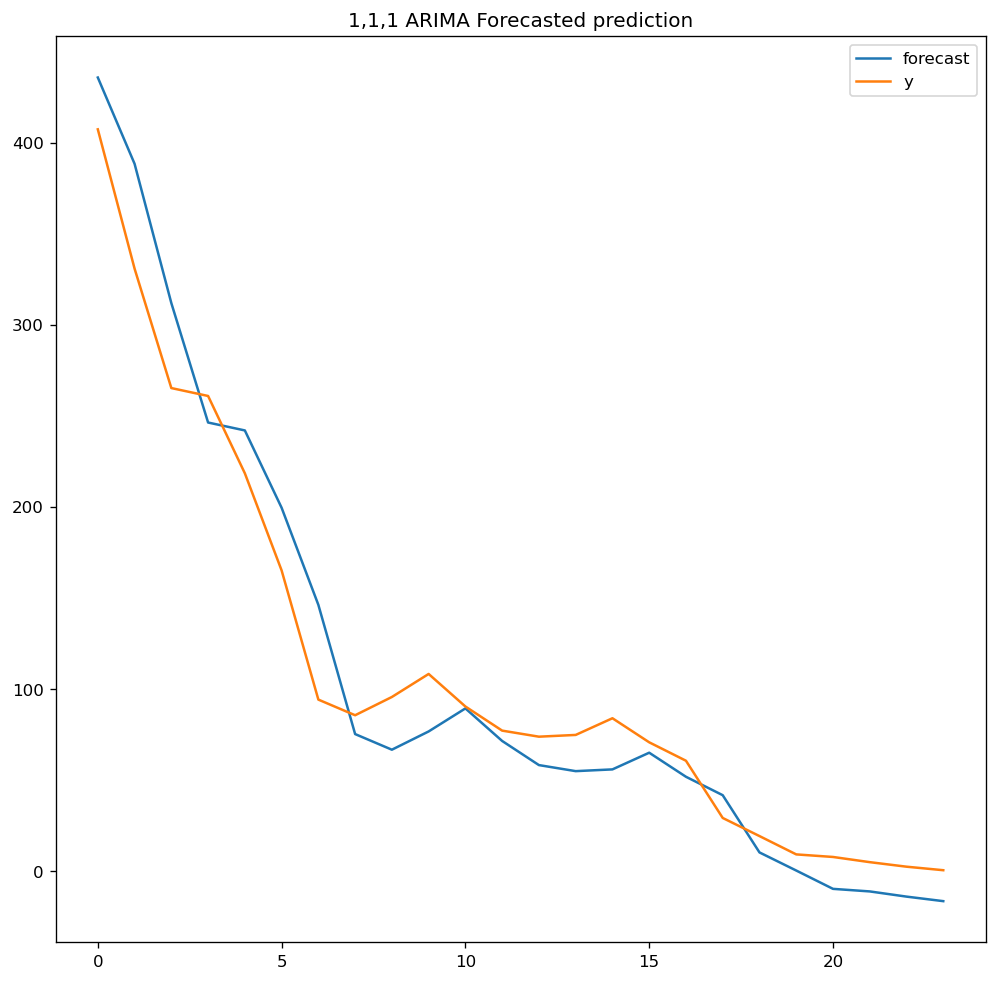

In [153]:
#Actual vs. Forecasted using 1,1,1 ARIMA
Middlesex_model_fit.plot_predict(dynamic=False)
plt.title('1,1,1 ARIMA Forecasted prediction')
plt.show()

From earlier when doing ARIMA on the entire dataset, we saw the 1,1,3 model was better. Let's see if that applies here with the Middlesex Data.

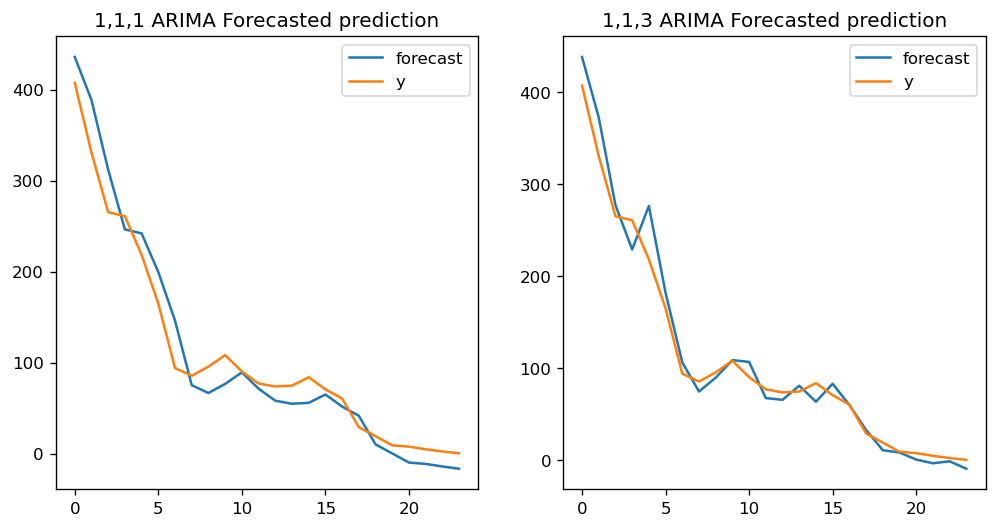

In [154]:
# 1,1,3 ARIMA Model
Middlesex_model_113 = ARIMA(Middlesex.values, order=(1,1,3))
Middlesex_model_fit_113 = Middlesex_model_113.fit()

fig, ax = plt.subplots(1,2, figsize=(10,5))
Middlesex_model_fit.plot_predict(dynamic=False, ax=ax[0])
ax[0].set_title('1,1,1 ARIMA Forecasted prediction')

Middlesex_model_fit_113.plot_predict(dynamic=False, ax=ax[1])
ax[1].set_title('1,1,3 ARIMA Forecasted prediction')

#plt.tight_layout()
plt.show()

In [155]:
print(Middlesex_model_fit_113.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   24
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -103.330
Method:                       css-mle   S.D. of innovations             15.702
Date:                Wed, 25 Aug 2021   AIC                            218.660
Time:                        13:00:11   BIC                            225.729
Sample:                             1   HQIC                           220.535
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.2369      4.362     -3.722      0.000     -24.786      -7.688
ar.L1.D.y      0.8204      0.154      5.344      0.000       0.520       1.121
ma.L1.D.y      0.0694      0.248      0.280      0.7

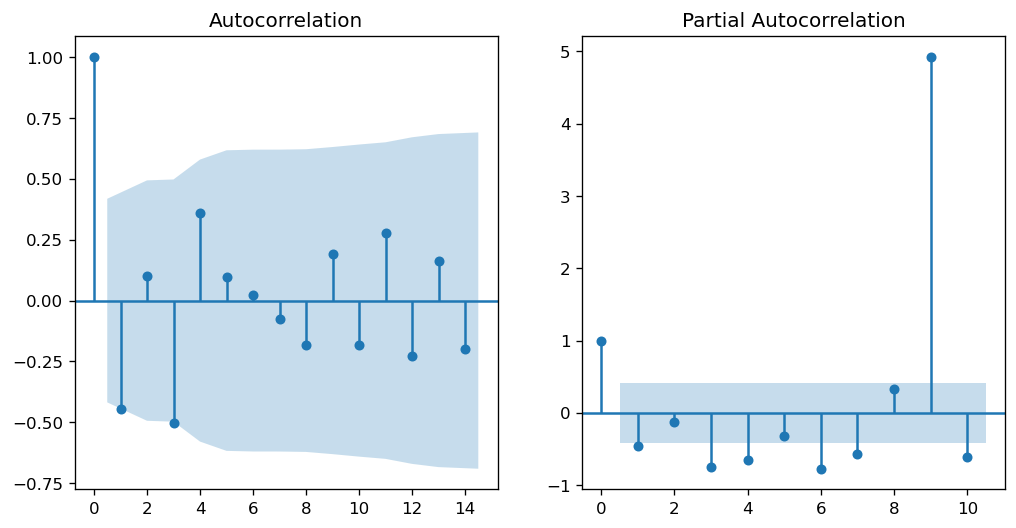

In [156]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
#Third Order Differencing of Middlesex Data

plot_acf(pacf_test.diff().diff().diff().dropna(), ax=ax[0])
plot_pacf(pacf_test.diff().diff().diff().dropna(), lags=((pacf_test.shape[0] // 2) -2), ax=ax[1])

plt.show()

Graphically 1,1,1 and 1,1,3 looks different. 
1,1,1 follows the actual line better, but 1,1,3's forecast line is closer to the actual one. 

The summary of 1,1,3 yields a better AIC but its ACF and PACF would not pass the smell test. I will stick with 1,1,1 model but will cross-validate for any the possibility of better parameters.

## Out-of-Time Cross Validation
1. Requires partitioning the time series
2. Takes steps back and then forecast into the future with as many steps taken backwards
3. Compare forecast against the actuals

In [157]:
#create a Training and Testing Set
#There are 25 nobs for Middlesex, I'll split it 20:5
#Lesson learned - by manually setting the partition, this may impede future ML attempts!
Middlesex.shape

#If I had time, I think this is where I would've implemented the windowing function
#Where I partitioned a subset of the timeseries to train, and then subset+1 to test
#I'd then perform some kind of gradient boosting on that model and continue onto the next subsetted window
train = Middlesex[:20]
test = Middlesex[20:]

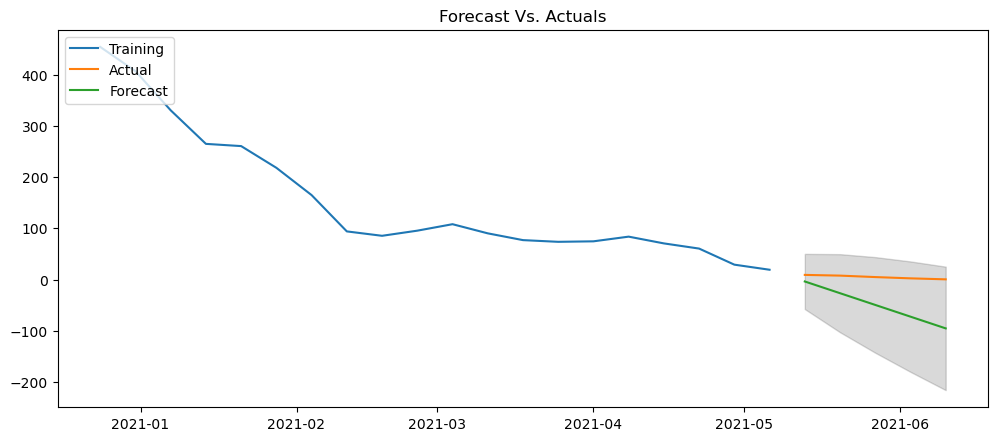

In [158]:
#Buildling ARIMA Model
model = ARIMA(train, order=(1,1,1))
fitted = model.fit(disp=-1)

#forecast with 95% confidence
fc, se, conf = fitted.forecast(5, alpha=0.05)

#make a panda series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

#plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)

plt.title('Forecast Vs. Actuals')
plt.legend(loc='upper left')
plt.show()

### Something is rotten in Denmark...
Forecast is going down, whilst actual isn't. The direction is off.

I will try implementing stepwise increments to the p,d,q terms using auto_arima()
to see if my forecast can improve.

## Automating ARIMA

In [83]:
#Making a dict where keys() are counties and values() are their auto_arima() models
counties_dict = {} #k:v are county:df
counties_ARIMA = {}
for county in df_0.County.unique():
    counties_dict[county] = pd.DataFrame(df_0.loc[df_0['County']==county,
                                    'normalized_concentration_rolling_average'].drop_duplicates())

for county, df in counties_dict.items():
    model = pm.auto_arima(df.values, start_p=1, start_q=1,
                          test='adf', max_p=3, max_q=3, max_d=3,
                          m=1, d=1, seasonal=False,
                          start_P=0, D=0, trace=True, error_action='ignore',
                          suppress_warnings=True, stepwise=True)
    counties_ARIMA[county] = model

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=241.703, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=249.120, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=243.797, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=242.776, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=247.487, Time=0.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=233.135, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=230.446, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=231.065, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=230.447, Time=0.03 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 0.589 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=253.418, Time=0.04 sec
 ARI

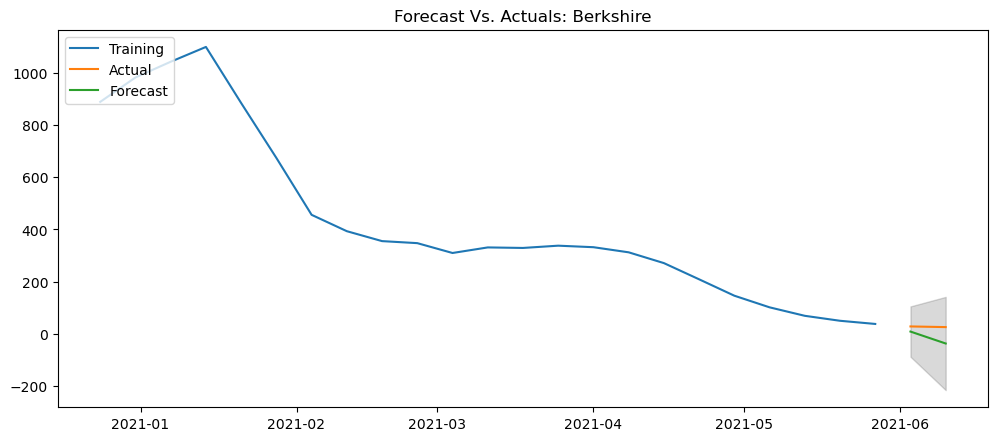

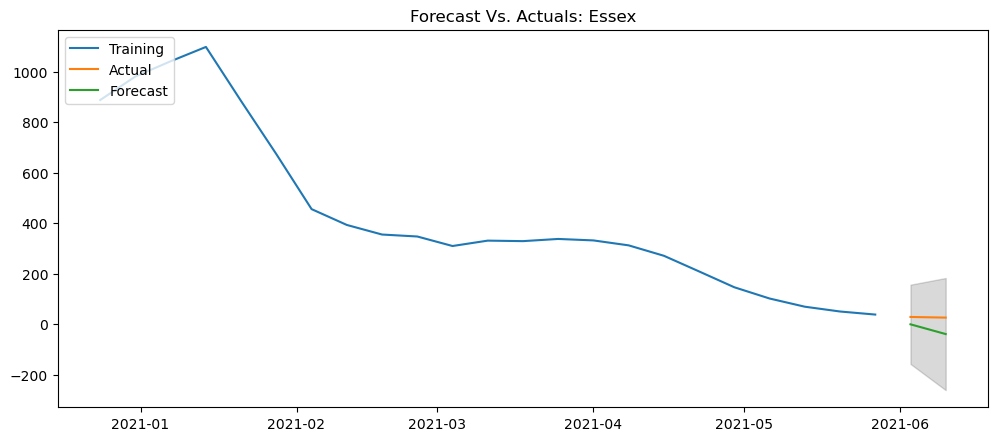

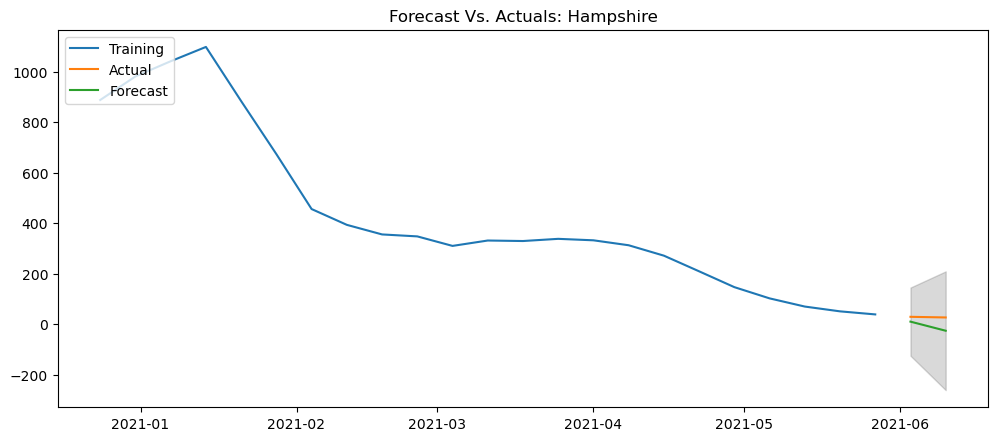

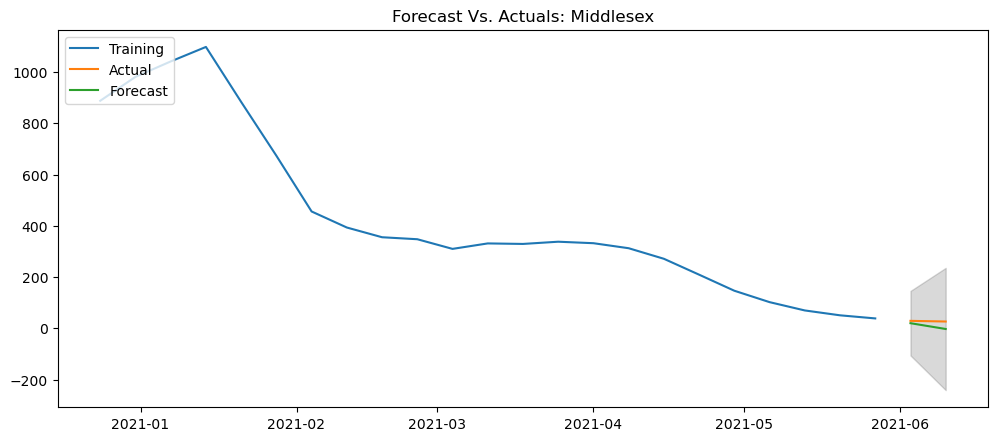

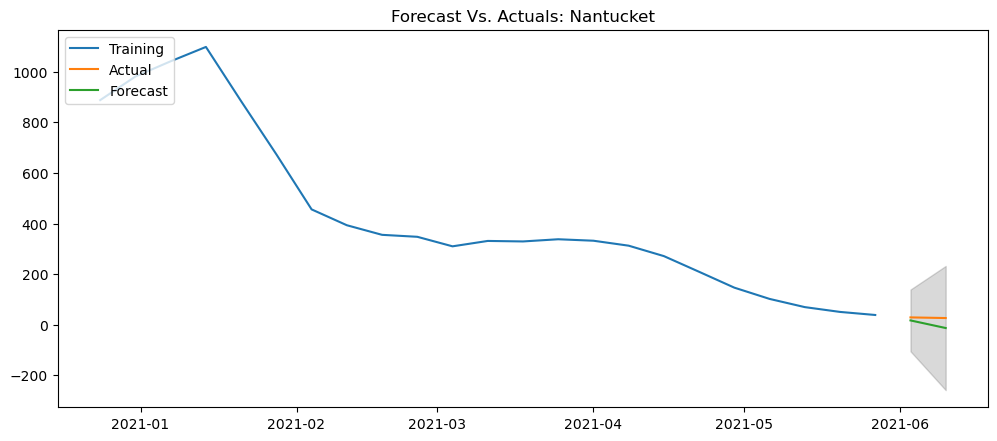

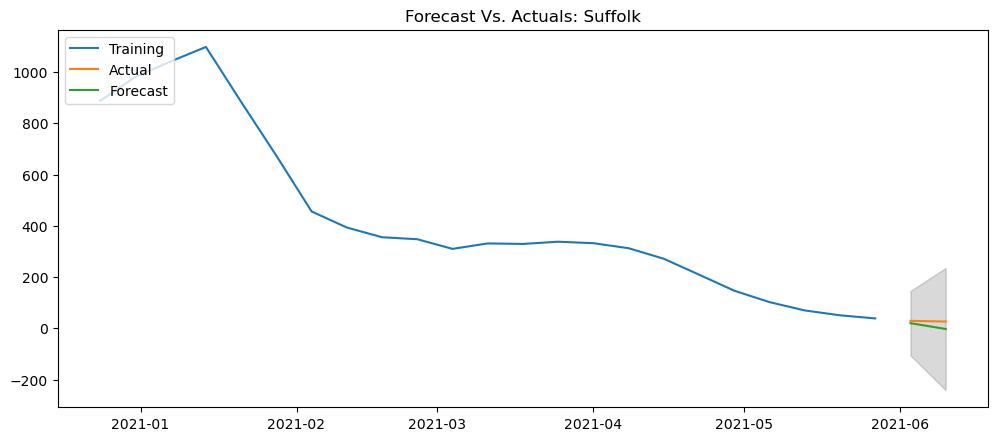

In [160]:
import re #Must move this to the beginning of the notebook

#reminder: I already computed best p,d,q terms from auto_arima()
#it is stored in counties_ARIMA.values() and i'll call it as 'best_model' below

for county, best_model in counties_ARIMA.items():
    for county_, df in counties_dict.items():
        if county == county_:
            #Defining the test train partition using the shape of the dataframe
            #whatever is being multiplied to .shape[0] is the test size percentage
            test_size = round(df.shape[0]*.10)
            df_slice = int(df.shape[0]) - test_size
        
        #This is not a good time-series partition
        #As the partition is a percentage of the series, eventually it will yield a line
        #train = df[:df_slice]
        #test = df[df_slice:]
        train = df[:-2]
        test = df[-2:]

    #convert best_model into a string, and then slice it to extract needed p,d,q values
    text = str(best_model)
    x = text[6:13] #this is the slice of the (p,d,q) in best_model
    p,d,q = int(x[1]), int(x[3]), int(x[5])
    
    #Create the ARIMA model using train and the auto_arima p,d,q values
    model = ARIMA(train, order=(p,d,q))
    fitted = model.fit(disp=-1)

    #forecast with 95% confidence
    fc, se, conf = fitted.forecast(len(test), alpha=0.05)

    #make a panda series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    #Plot all the counties 
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='Training')
    plt.plot(test, label='Actual')
    plt.plot(fc_series, label='Forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)

    plt.title('Forecast Vs. Actuals: ' + str(county))
    plt.legend(loc='upper left')
    #plt.show()

## Methods for ARIMA forecasting by County 

In [84]:
def County_modelling(county: str, dict_ARIMA: dict, 
                    dict_counties: dict, feature: str, test_size: float,
                    print_stats: bool):
    '''
    A method to do forecast a feature using the ARIMA time-series model.
    Parameters:
    county: (string), the county which we want to forecast
    dict_ARIMA: (dict) holds the best ARIMA model as calculated by auto_arima
    dict_counties: (dict) holds the dataframe with the feature we will be forecasting
    feature: (string) the feature we want to use to do the forecasting
    test_size: (float) the decimal representing the percentage of the test partition
    print_stats: (boolean) a flag to print the accuracy metrics of the ARIMA model
    '''
    if feature == None or feature == '':
        feature_ = 'normalized_concentration_rolling_average'
    else: feature_ = feature
    for a_county, best_model in dict_ARIMA.items():

        for county_, df in dict_counties.items():
            
            #A filter to ensure that the county parameter matches that in our two supplied dicts
            #Once again, this is not a good way to partition a time-series. Deprecate
            if county_ == county and a_county == county_:

                #Defining the test train partition using the shape of the dataframe
                #whatever is being multiplied to .shape[0] is the test size percentage
                
                
                test_slice = round(df.shape[0]*test_size)
                df_slice = int(df.shape[0]) - test_slice
                
    
    #convert best_model into a string, and then slice it to extract needed p,d,q values
    text = str(best_model)
    x = text[6:13] #this is the slice of the (p,d,q) in best_model
    
    #Note there are 7 items in x, and the 1st, 3rd, and 5th items are the p,d,q values
    p,d,q = int(x[1]), int(x[3]), int(x[5])
    
    #slicing the time-series
    #Deprecate - not appropriate partition for time-series
    #train = df[:df_slice]
    #test = df[df_slice:]
    
    #partitions should be done based on how many lags are used in the model.
    train = df[:-2]
    test = df[-2:]
    print(train.shape, test.shape)

    #Create the ARIMA model using train and the auto_arima p,d,q values
    model = ARIMA(train, order=(p,d,q))
    fitted = model.fit(disp=-1)

    #forecast with 95% confidence
    fc, se, conf = fitted.forecast(len(test), alpha=0.05)

    #make a panda series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    #Plot all the counties 
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='Training')
    plt.plot(test, label='Actual')
    plt.plot(fc_series, label='Forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)

    if feature == None or feature == '': 
        plt.title(f'{p},{d},{q} ARIMA Forecast Vs. Actuals: ' + str(county))    
    else: 
        plt.title(str(feature) + f' {p},{d},{q} ARIMA Forecast Vs. Actuals: ' + str(county))
    plt.legend(loc='upper left')
    plt.show()

    #Defining my accuracy metrics

    actual = test[feature_]

    #MAPE - Mean Absolute Percentage Errors
    #print(fc_series.values,'\n', test.values)
    mape = np.mean(np.abs(fc_series.values - actual.values)/np.abs(actual.values)) 

    #MAE - Mean Absolute Error
    mae = np.mean((fc_series.values - actual.values)/actual.values)

    #Mean Error
    me = np.mean(fc_series.values - actual.values)

    #Correlation between actual and forecast
    #print(fc_series, fc_series.shape, '\n', actual, actual.shape)
    corr = np.corrcoef(fc_series.values, actual.values)[0,1]

    #Min-Max Error
    mins = np.amin(np.hstack([fc_series.values[:,None],
                              actual.values[:,None]]), axis=1)

    maxs = np.amax(np.hstack([fc_series.values[:,None],
                              actual.values[:,None]]), axis=1)

    minmax = 1 - np.mean(mins/maxs)

    if print_stats == True:
        print('MAPE: ', mape, '\nMAE: ', mae, '\nME: ', me,
              '\nCorrelation: ', corr, '\nMin-Max: ', minmax)

In [162]:
def County_forecast(county: str, dict_ARIMA: dict, 
                    dict_counties: dict, feature: str, 
                    test_size: float, suppress_plot: bool):
    '''
    A method to do forecast a feature using the ARIMA time-series model.
    Parameters:
    county: (string), the county which we want to forecast
    dict_ARIMA: (dict) holds the best ARIMA model as calculated by auto_arima
    dict_counties: (dict) holds the dataframe with the feature we will be forecasting
    feature: (string) the feature we want to use to do the forecasting
    test_size: (float) the decimal representing the percentage of the test partition
    '''
    if feature == None or feature == '':
        feature_ = 'normalized_concentration_rolling_average'
    else: feature_ = feature
    for a_county, best_model in dict_ARIMA.items():

        for county_, df in dict_counties.items():
            
            #A filter to ensure that the county parameter matches that in our two supplied dicts
            if county_ == county and a_county == county_:

                #convert best_model into a string, and then slice it to extract needed p,d,q values
                text = str(best_model)
                x = text[6:13] #this is the slice of the (p,d,q) in best_model
                
                data = df
                #Note there are 7 items in x, and the 1st, 3rd, and 5th items are the p,d,q values
    p,d,q = int(x[1]), int(x[3]), int(x[5])

    


    #Create the ARIMA model using train and the auto_arima p,d,q values
    model = ARIMA(data, order=(p,d,q))
    fitted = model.fit(disp=-1)
    print(fitted)

    
    #forecast
    n_periods = 2
    index_of_fc = pd.date_range(df.index[-1], periods=n_periods, freq='W')

    #setting the param in forecast as n_periods means we are asking for out of sample forecasts
    #n_periods must match with th length we use in our plotting series in index=
    forecast, se, confint = fitted.forecast(n_periods, alpha=0.05)
    

    #forecast with 95% confidence
    #fc, se, conf = fitted.forecast(len(test), alpha=0.05)

    #make series for plotting purpose
    forecast_series = pd.Series(forecast, index=index_of_fc)
    lower_series = pd.Series(confint[:,0], index=index_of_fc)
    upper_series = pd.Series(confint[:,1], index=index_of_fc)

    if suppress_plot==False:
       #Plot all the counties 
        plt.figure(figsize=(12,5), dpi=100)
        plt.plot(data)
        plt.plot(forecast_series, label='Forecast', color='orange')
        plt.fill_between(lower_series.index, 
                         lower_series, 
                         upper_series, 
                         color='k', 
                         alpha=0.15)

        if feature == None or feature == '': 
            plt.title(f'{p},{d},{q} ARIMA Forecast: ' + str(county))    
        else: 
            plt.title(str(feature) + f' {p},{d},{q} ARIMA Forecast: ' + str(county))
        plt.legend(loc='upper left')
        plt.show()  
    else:
        print(fitted.summary())
        

In [163]:
def ARIMA_diagnostics(county: str, dictionary: dict):
    for County,Model in dictionary.items():
        if County==county:
            Model.plot_diagnostics()
    plt.show()

(23, 1) (2, 1)


C:\Users\Aim\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Aim\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-THU wil

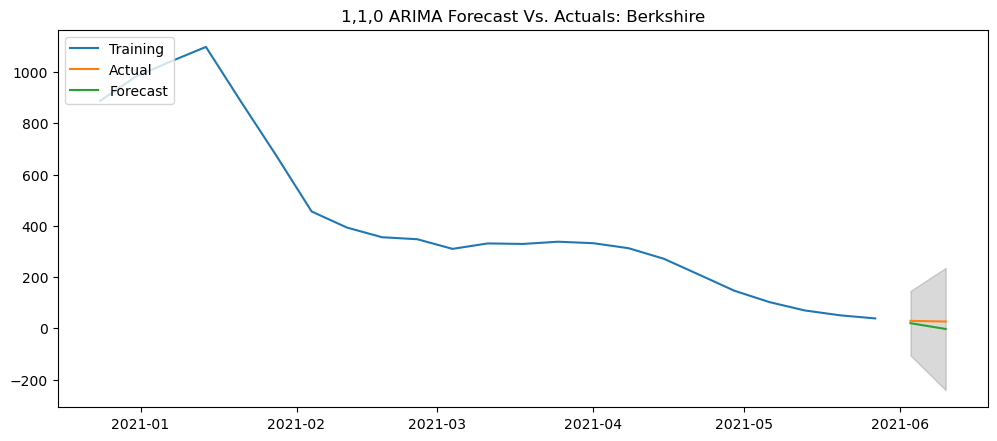

MAPE:  0.7093516844433347 
MAE:  -0.7093516844433347 
ME:  -19.147288296342147 
Correlation:  1.0 
Min-Max:  0.7093516844433349


In [85]:
County_modelling('Berkshire', counties_ARIMA, counties_dict, None, 0.1, True)

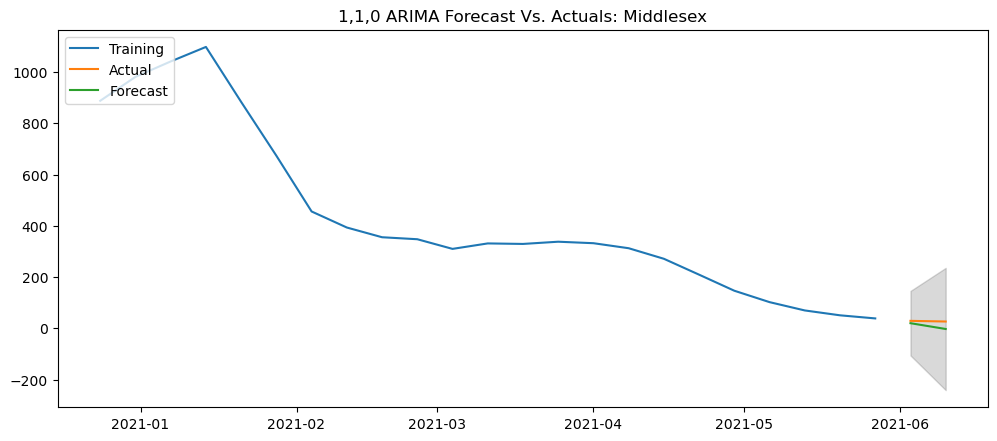

MAPE:  0.7093516844433347 
MAE:  -0.7093516844433347 
ME:  -19.147288296342147 
Correlation:  1.0 
Min-Max:  0.7093516844433349


In [165]:
County_modelling('Middlesex', counties_ARIMA, counties_dict, None, 0.1, True)

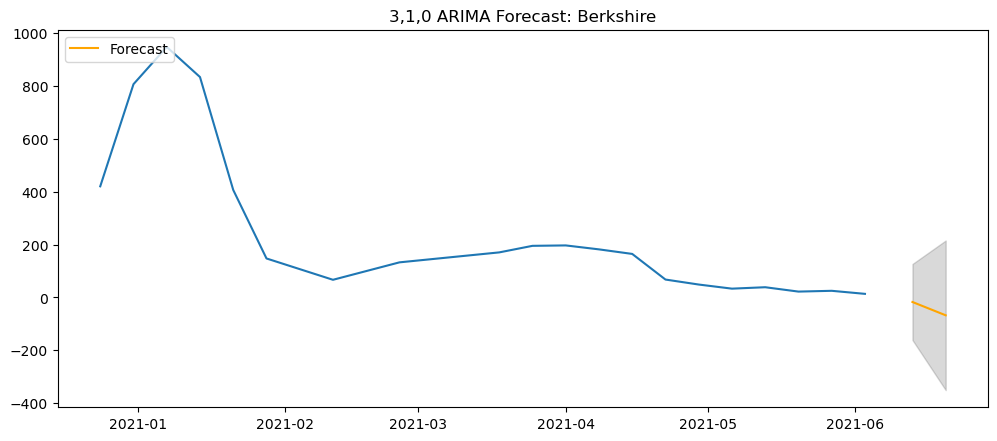

In [167]:
#You can toggle the suppress_plot flag with True/False. 
#Feel free to try out the forecast with different counties. 
County_forecast('Berkshire', counties_ARIMA, counties_dict, None, 0.1, False)

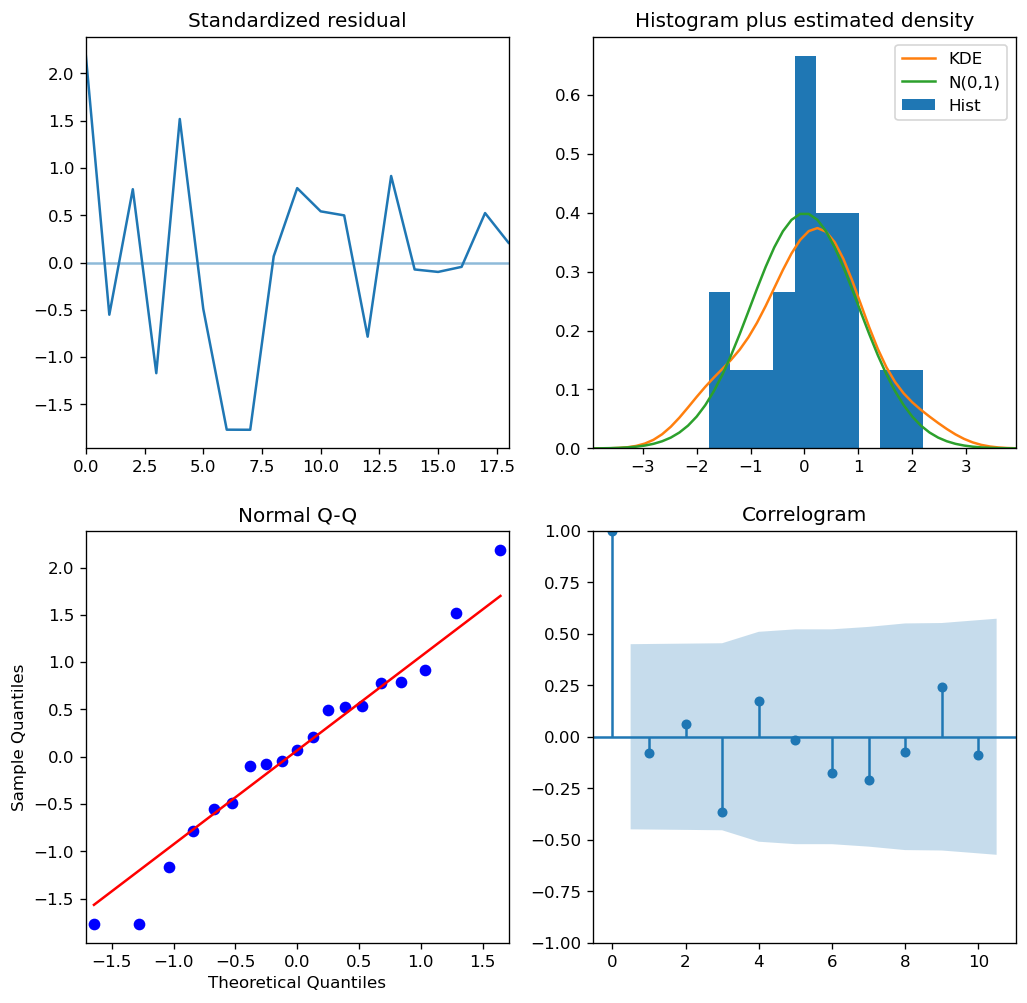

In [168]:
ARIMA_diagnostics('Berkshire', counties_ARIMA)

# What I've learned:
1. How to forecast time-series data
2. How time-series forecast depends on the stationarity of the dataset
3. Time-series models such as AR, MA, and ARIMA.

## What I wish I could do:
1. How to introduce exogenous features into the analysis, think (vaccine rates and dominant variants R0)

### What would be next?
If I had the time, I would like to understand how the data may be seasonal, but since the surveilled data is in weekly observations, and less than a years' worth of data, it is not possible now.

# TL;DR
Time series depends on stationarity. Not all the county-level data exhibited stationarity and so I took the differences of the dataset in attempt to make it more stationary. 

Using the AIC as the scoring criteria, I used auto_arima to find the best time-series model to forecast the concentration of Covid-19 mRNA in the wastewaters of six Massachusetts counties.

My forecast model was bad. Looking at the Mean Average Percentage Error, roughly 70% of my predictions were erroneous. 


## Note to Reader:
If you've made it this far, thank you for your patience. 